In [1]:
# Importing libraries
import re
import sys
import json
import praw
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.lda_model
from itertools import chain
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter
from praw.models import MoreComments

# Importing Scikit-learn libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Importing NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer




# Downloading NLTK stopwords
nltk.download('stopwords')
# Downloading NLTK vader lexicon
nltk.download('vader_lexicon')
# Downloading NLTK punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-v0_8")

# Setting aesthetic parameters for plots
sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

In [ ]:
import pandas as pd
import json

# Path to your JSON file
file_path = '../Data/youtube_merged_all_videos_with_comments.json'


# Load the JSON data
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Build a list of records: one 'video' row (title+description) followed by its comments
records = []
for video in data:
    vid = video.get('videoId', '')
    title = video.get('title', '')
    desc = video.get('description', '')
    
    # First row: title + description
    records.append({
        'videoId': vid,
        'text': f"{title}\n\n{desc}",
        'type': 'video'
    })
    # Subsequent rows: each comment
    for comment in video.get('comments', []):
        comment_text = (
            comment.get('text') or
            comment.get('textDisplay') or
            comment.get('textOriginal') or
            ''
        )
        records.append({
            'videoId': vid,
            'text': comment_text,
            'type': 'comment'
        })

# Create DataFrame
df = pd.DataFrame(records)


       videoId                                               text     type
0  2JsmSs3oPjc  Russia in 'far worse position now' than during...    video
1  2JsmSs3oPjc  I only clicked to see how the bias from sky wa...  comment
2  2JsmSs3oPjc  The Russians have moved 30 miles through heavy...  comment
3  2JsmSs3oPjc                              I'm tired of this guy  comment
4  2JsmSs3oPjc  Clarke is a Govt propaganda stooge from Chatha...  comment
(14121, 3)


In [4]:
df.head()

videoId                                               text     type
0  2JsmSs3oPjc  Russia in 'far worse position now' than during...    video
1  2JsmSs3oPjc  I only clicked to see how the bias from sky wa...  comment
2  2JsmSs3oPjc  The Russians have moved 30 miles through heavy...  comment
3  2JsmSs3oPjc                              I'm tired of this guy  comment
4  2JsmSs3oPjc  Clarke is a Govt propaganda stooge from Chatha...  comment

In [5]:
# # Take text as array of strings
# text = df['text'].astype(str).tolist()

In [6]:
# text[:5]

In [7]:
# df = pd.DataFrame({'text': text})

In [8]:

tokenizer = RegexpTokenizer(r"[a-zA-Z]+(?:[-'][a-zA-Z]+)?")
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))


# Basic cleaning & abbreviation setup
abbreviations = {
    "lol": "laugh out loud", "omg": "oh my god", "idk": "i don't know",
    "rn": "right now", "u": "you", "ur": "your", "btw": "by the way",
    "brb": "be right back", "thx": "thanks", "pls": "please", "imo": "in my opinion",
    "fwiw": "for what it's worth", "lmao": "laughing my ass off"
}

#  Clean + tokenize + stem function
def process_text(text):
    if not text or not isinstance(text, str):
        return []
 
    # Lowercase, remove zero-width spaces
    text = text.replace('\u200b', '').lower()
 
    # Expand abbreviations
    for abbr, full in abbreviations.items():
        text = re.sub(rf'\b{abbr}\b', full, text)
 
    # Remove URLs and mentions
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove non-ASCII characters (emojis, special symbols)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
 
    # Tokenize
    tokens = tokenizer.tokenize(text)
 
    # Remove stopwords and short tokens
    tokens = [t for t in tokens if len(t) > 1 and t not in stop_words]
 
    # Stemming
    stemmed_tokens = [stemmer.stem(t) for t in tokens if t.isalpha()]
    return stemmed_tokens
    # return tokens
 


 
 

In [9]:
df['processed_tokens'] = df['text'].apply(process_text)

In [10]:
# Create word frequency dictionary
all_words = [word for tokens in df['processed_tokens'] for word in tokens]
word_freq = Counter(all_words)

# Remove rare words (frequency = 1)
words_to_keep = {word for word, count in word_freq.items() if count > 1}
df['processed_tokens'] = df['processed_tokens'].apply(
    lambda tokens: [w for w in tokens if w in words_to_keep]
)


In [11]:

# Recreate clean text column after filtering rare words
df['clean_text_filtered'] = df['processed_tokens'].apply(
    lambda tokens: " ".join(tokens)
)


In [12]:

# Display processed data
print("Processed DataFrame:")
print(df[['text', 'processed_tokens', 'clean_text_filtered']].head())


Processed DataFrame:
                                                text  \
0  Russia in 'far worse position now' than during...   
1  I only clicked to see how the bias from sky wa...   
2  The Russians have moved 30 miles through heavy...   
3                              I'm tired of this guy   
4  Clarke is a Govt propaganda stooge from Chatha...   

                                    processed_tokens  \
0  [russia, far, wors, posit, talk, michael, clar...   
1  [click, see, bia, sky, go, get, wors, fool, an...   
2  [russian, move, mile, heavi, fortif, stalem, y...   
3                                        [tire, guy]   
4  [clark, govt, propaganda, stoog, hous, make, r...   

                                 clean_text_filtered  
0  russia far wors posit talk michael clark analy...  
1  click see bia sky go get wors fool anybodi bel...  
2  russian move mile heavi fortif stalem ye almos...  
3                                           tire guy  
4  clark govt propaganda stoog

In [13]:
df.head(5)

videoId                                               text     type  \
0  2JsmSs3oPjc  Russia in 'far worse position now' than during...    video   
1  2JsmSs3oPjc  I only clicked to see how the bias from sky wa...  comment   
2  2JsmSs3oPjc  The Russians have moved 30 miles through heavy...  comment   
3  2JsmSs3oPjc                              I'm tired of this guy  comment   
4  2JsmSs3oPjc  Clarke is a Govt propaganda stooge from Chatha...  comment   

                                    processed_tokens  \
0  [russia, far, wors, posit, talk, michael, clar...   
1  [click, see, bia, sky, go, get, wors, fool, an...   
2  [russian, move, mile, heavi, fortif, stalem, y...   
3                                        [tire, guy]   
4  [clark, govt, propaganda, stoog, hous, make, r...   

                                 clean_text_filtered  
0  russia far wors posit talk michael clark analy...  
1  click see bia sky go get wors fool anybodi bel...  
2  russian move mile heavi fortif stalem ye almos...  
3                                           tire guy  
4  clark govt propaganda stoog hous make ridicul ...

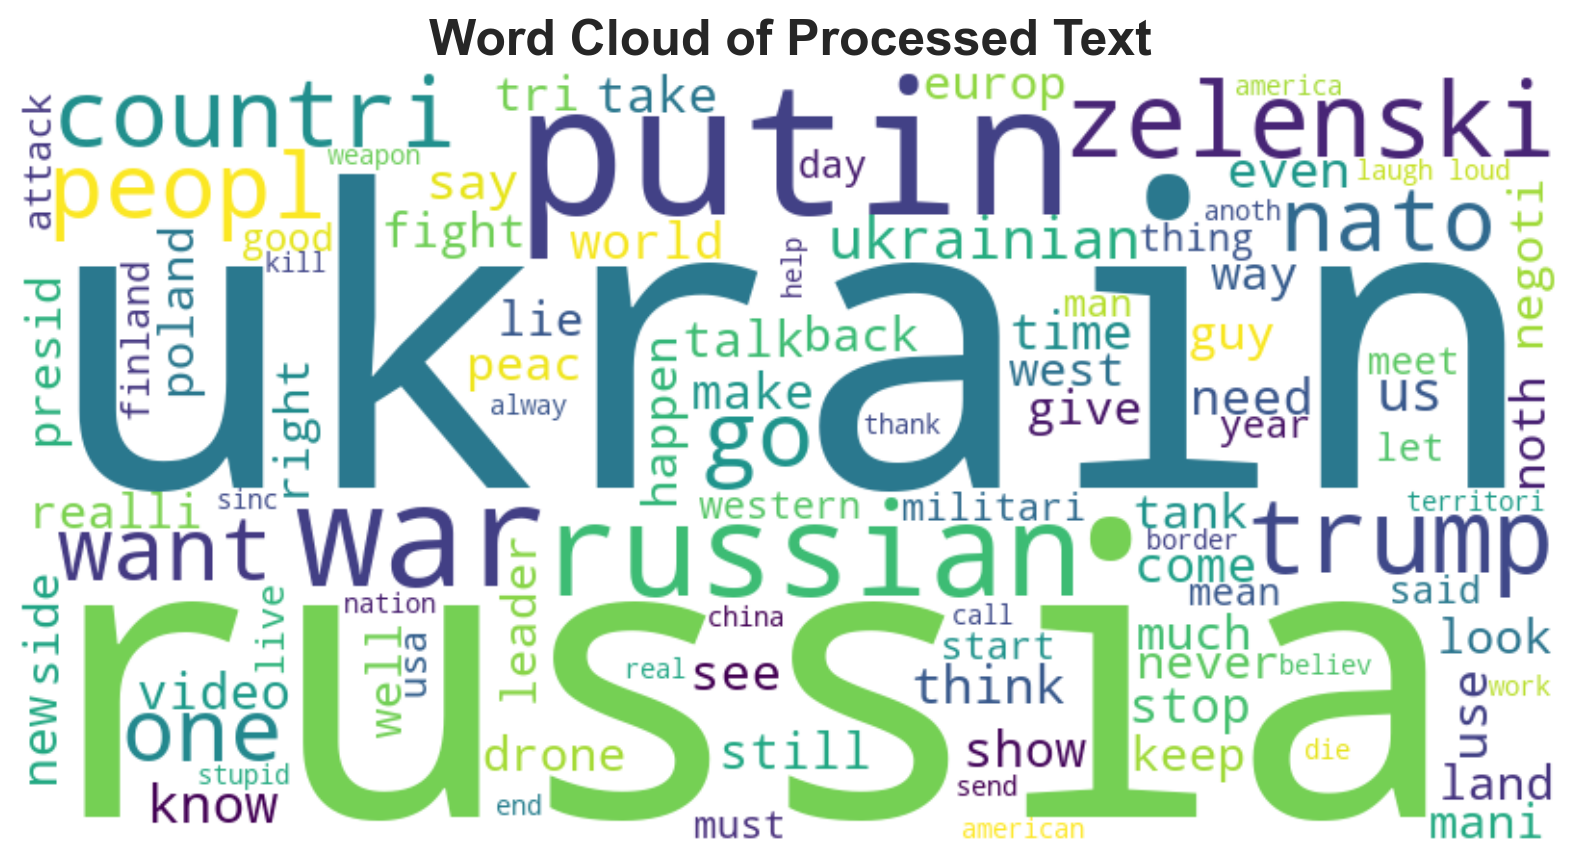

In [14]:

# Generate word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(df['clean_text_filtered'])
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     max_words=100).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Processed Text")
plt.show()


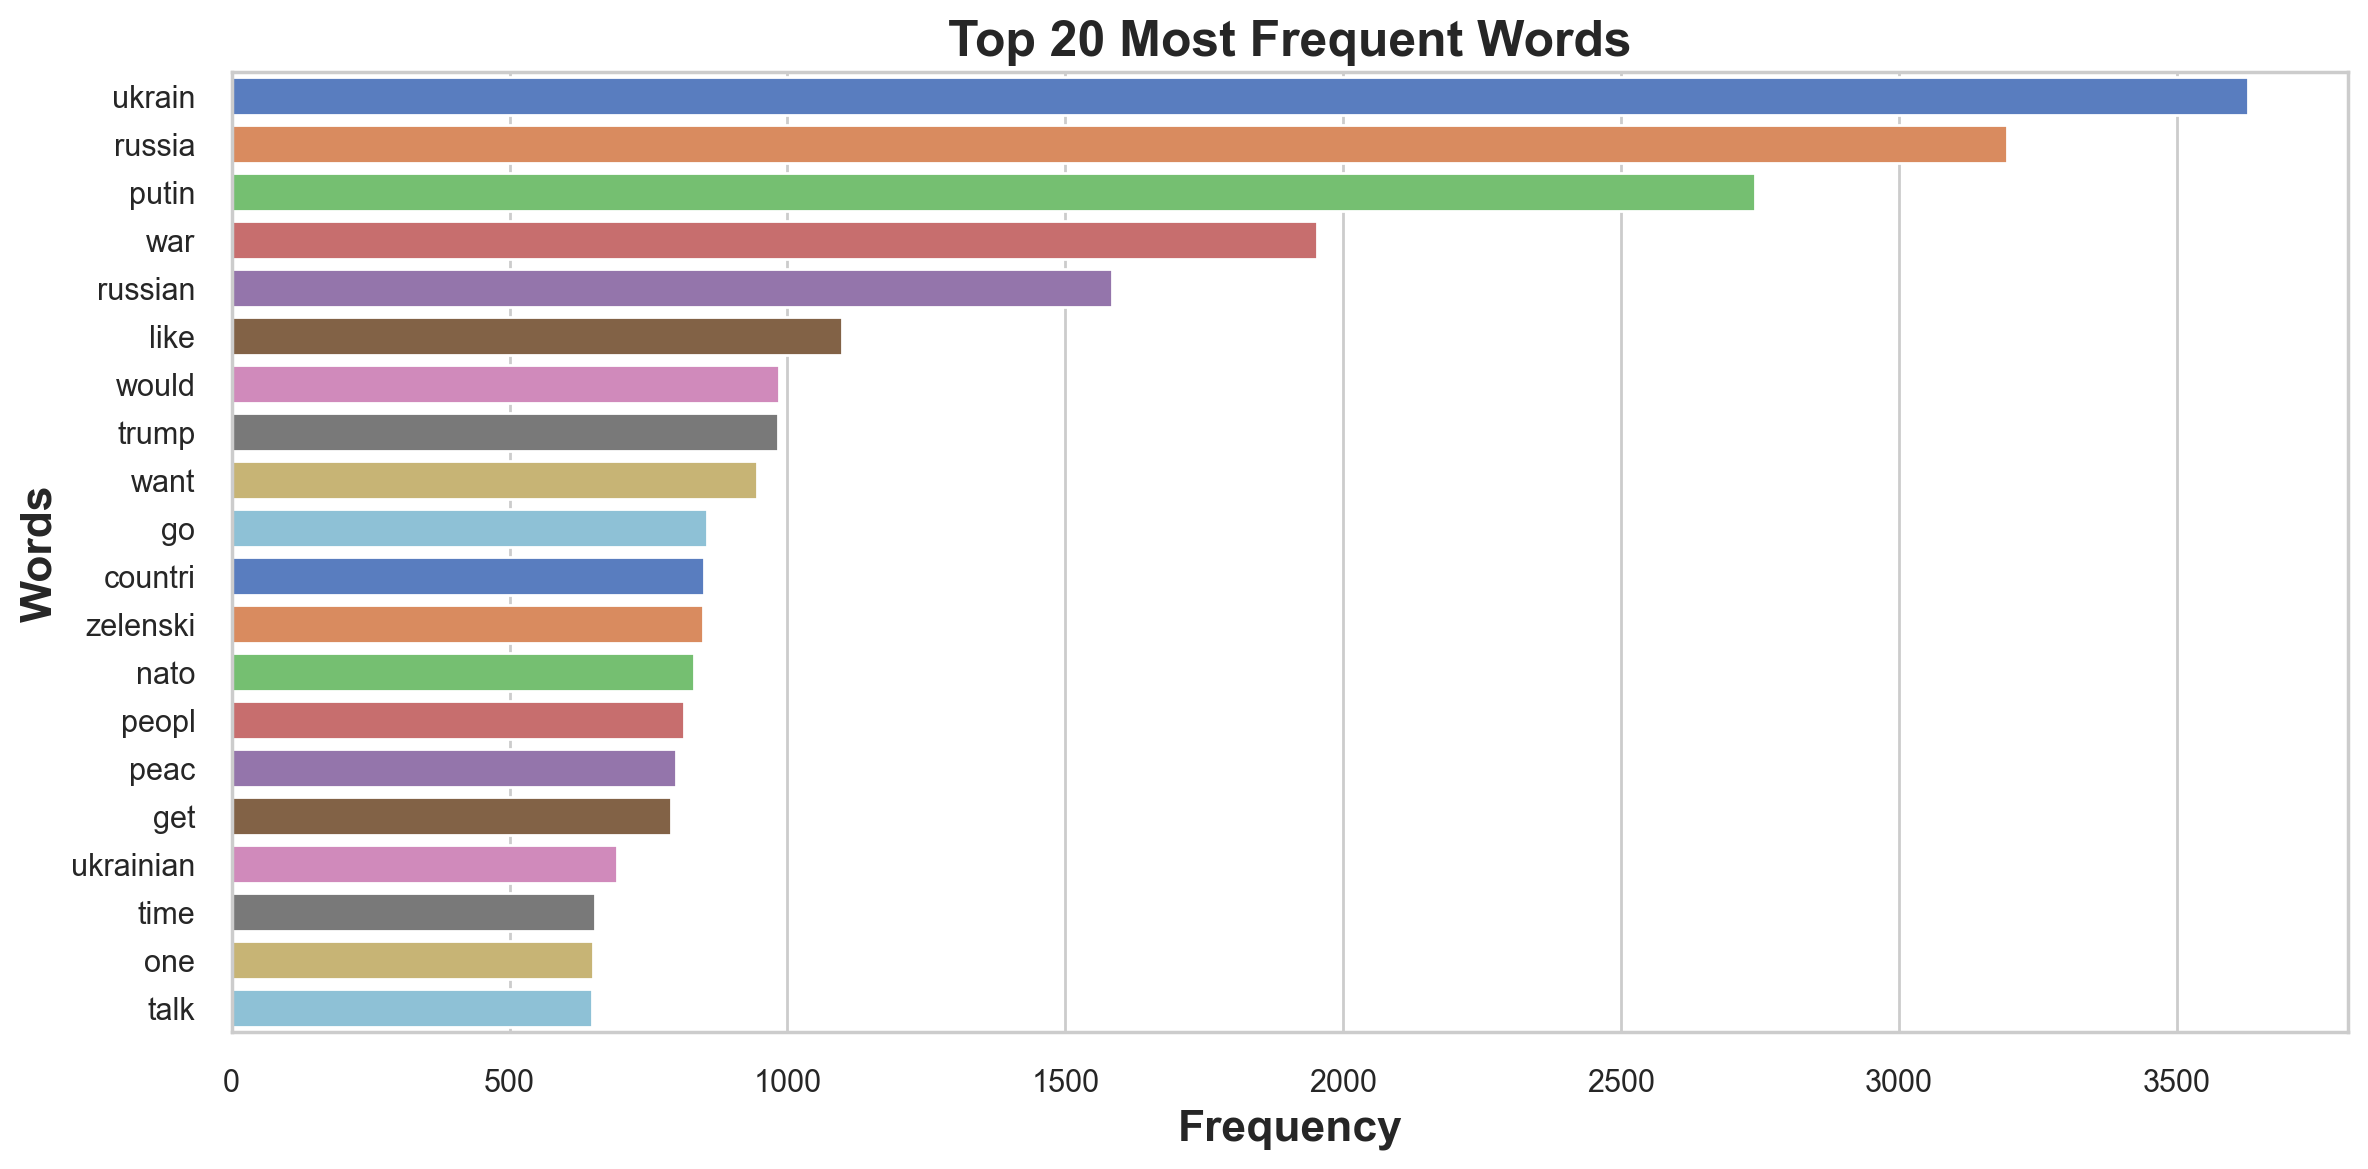

In [15]:

# Show top 20 most common words
top_words = word_freq.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
sns.barplot(x=counts, y=words, palette='muted', hue=words, orient='horizontal')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel('Words')
plt.tight_layout()
plt.show()




In [16]:
# Initializing VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Applying VADER sentiment scoring
df["sentiment_score"] = df["clean_text_filtered"].apply(lambda x: sid.polarity_scores(x)["compound"])


def classify_sentiment(score):
    if score >= 0.02:    # More lenient for Positive
        return "Positive"
    elif score <= -0.02: # More lenient for Negative
        return "Negative"
    return "Neutral"

# Apply classification
df["sentiment"] = df["sentiment_score"].apply(classify_sentiment)

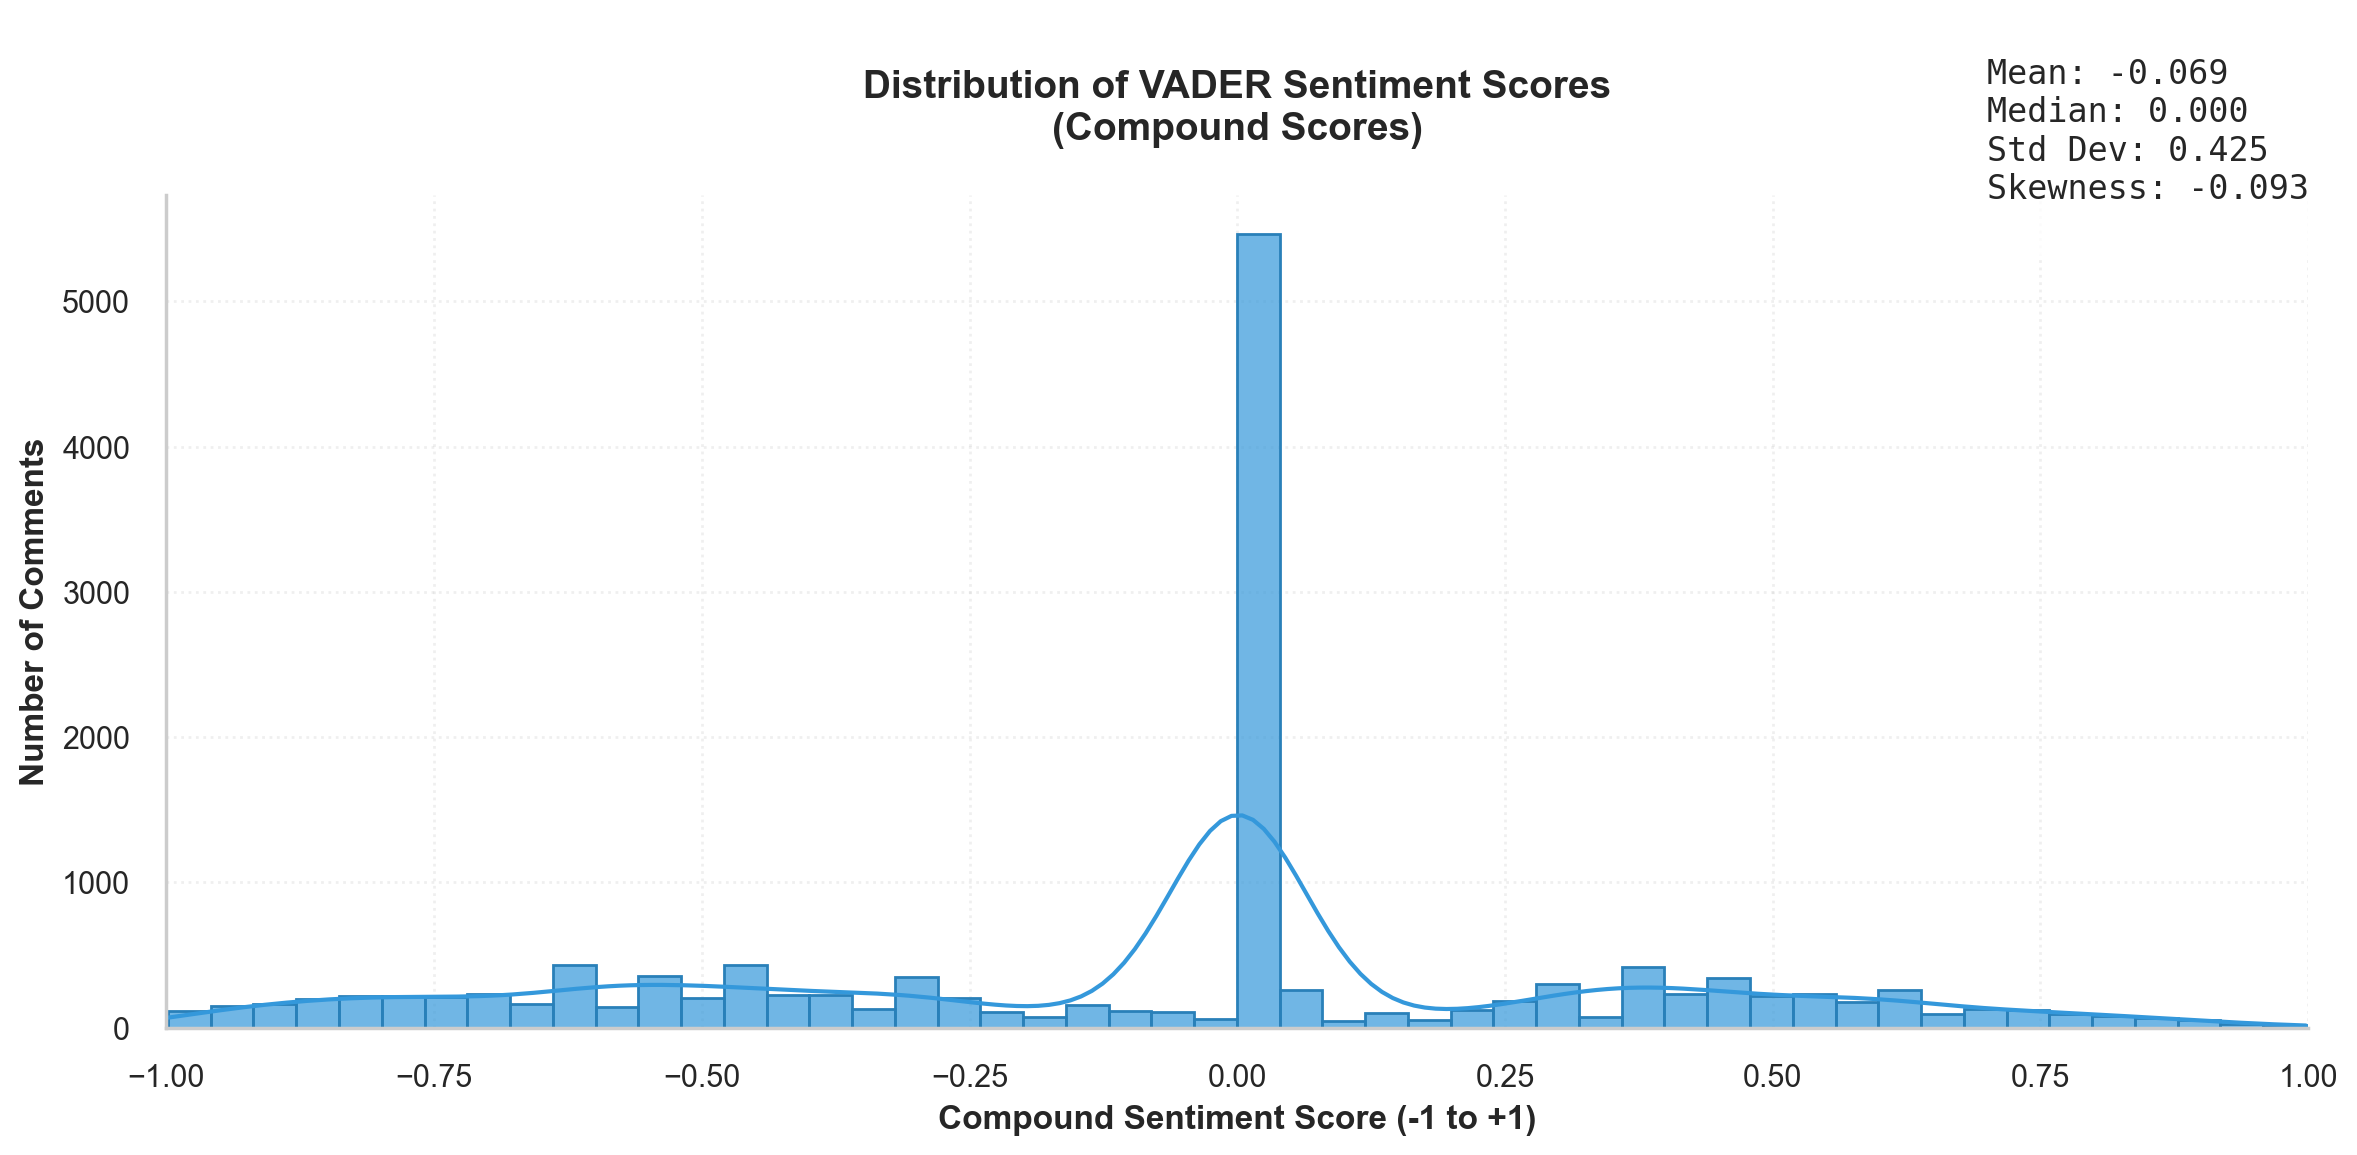

In [17]:
# Set up the figure
plt.figure(figsize=(12, 6))

# Create distribution plot
ax = sns.histplot(df['sentiment_score'], 
                 bins=50, 
                 kde=True,
                 color='#3498db',
                 edgecolor='#2980b9',
                 alpha=0.7)


# Formatting
plt.title('Distribution of VADER Sentiment Scores\n(Compound Scores)', 
         fontsize=14, pad=20)
plt.xlabel('Compound Sentiment Score (-1 to +1)', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.xlim(-1, 1)
plt.grid(True, linestyle=':', alpha=0.3)

# Add statistics box
stats_text = f"""
Mean: {df['sentiment_score'].mean():.3f}
Median: {df['sentiment_score'].median():.3f}
Std Dev: {df['sentiment_score'].std():.3f}
Skewness: {df['sentiment_score'].skew():.3f}
"""
plt.text(0.85, 0.95, stats_text, 
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8),
         fontfamily='monospace')

sns.despine()
plt.tight_layout()
plt.show()

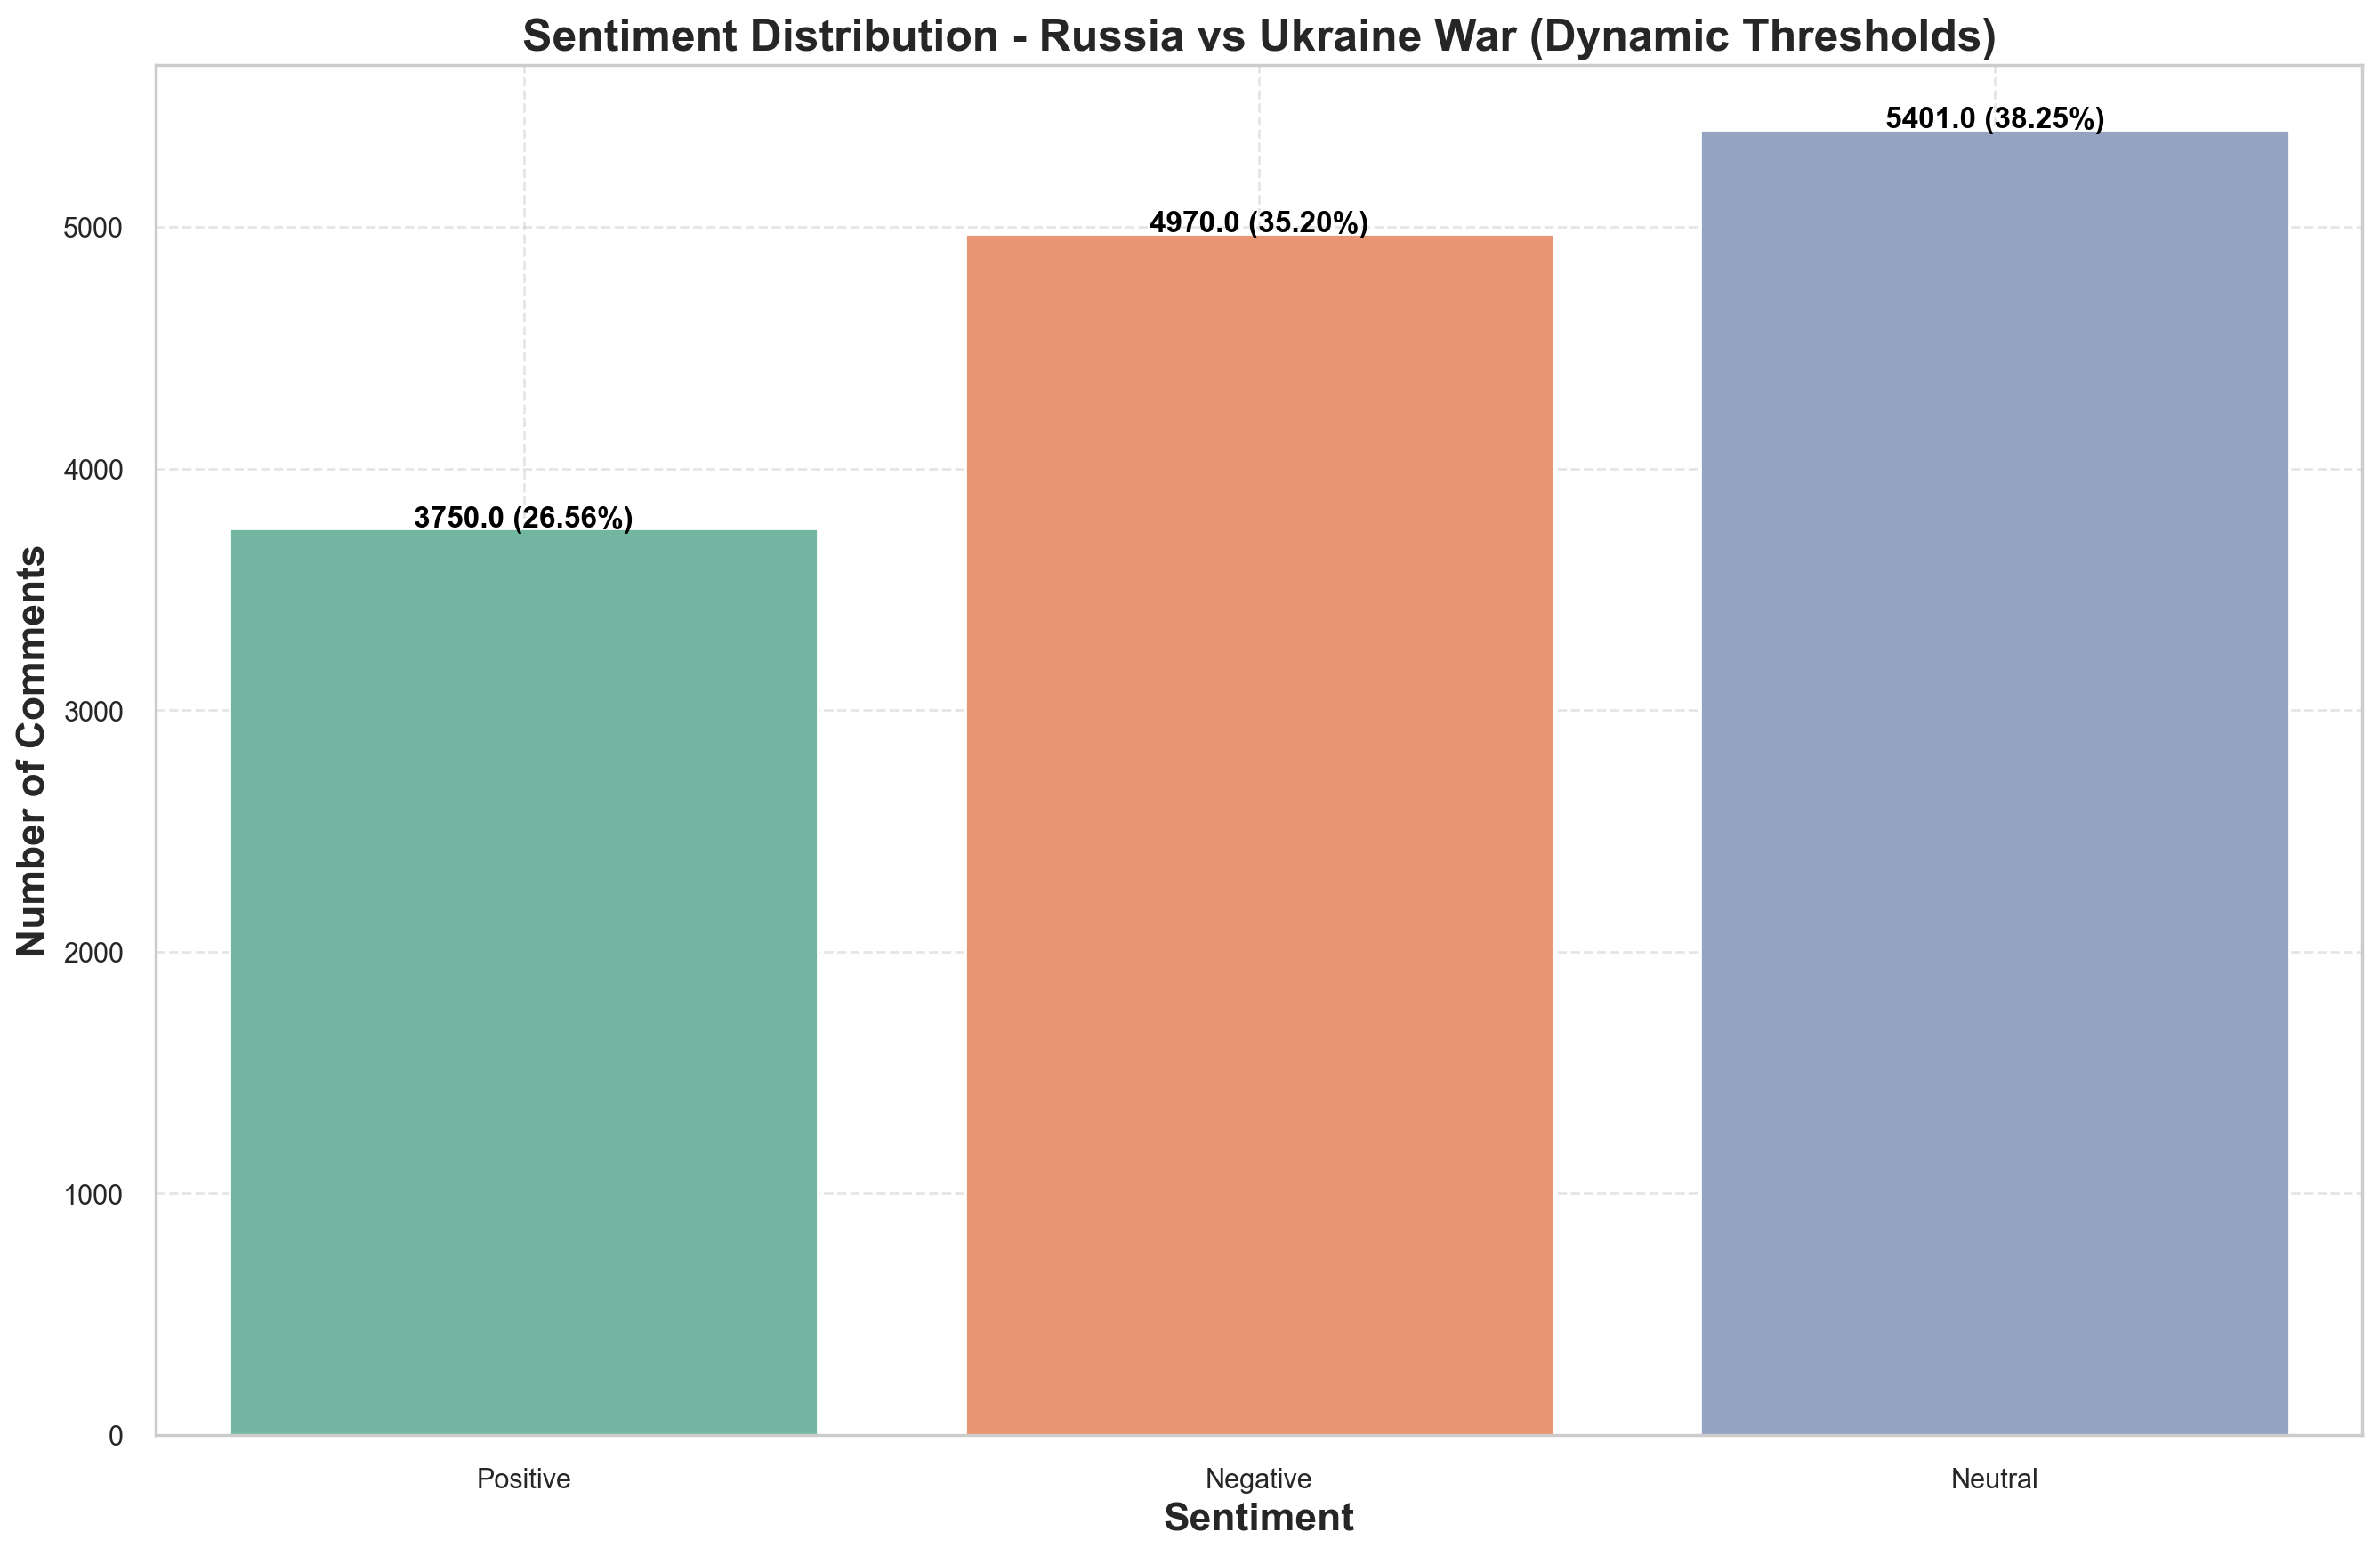

In [18]:
ax = sns.countplot(data=df, x='sentiment', palette='Set2', hue='sentiment')
plt.title("Sentiment Distribution - Russia vs Ukraine War (Dynamic Thresholds)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.grid(True, linestyle="--", alpha=0.5)
total = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.text(p.get_x() + p.get_width() / 2, height + 10, f'{height} ({percentage:.2f}%)',
            ha='center', fontweight='bold', color='black')
plt.show()

In [19]:
# Initilizing the corpus for LDA
corpus = df["clean_text_filtered"].tolist()

# Parameters for LDA and Vectorizers
min_df = 5
n_topics = 6
max_df = 0.95           
max_iter = 25
n_top_words = 10
max_features = 2000
seed_value = 999

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx + 1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Function to display word clouds for each topic
def display_word_cloud(model, feature_names, sup_title):
    normalised_components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topic_num = len(model.components_)
    col_num = 3
    row_num = int(math.ceil(topic_num / col_num))
    for topic_id, l_topic_dist in enumerate(normalised_components):
        l_word_prob = {feature_names[i]: _word_prob for i, _word_prob in enumerate(l_topic_dist)}
        wordcloud = WordCloud(background_color='black').generate_from_frequencies(l_word_prob)
        plt.subplot(row_num, col_num, topic_id + 1)
        plt.suptitle(sup_title, fontsize=20, fontweight='bold')
        plt.title(f'Topic {topic_id + 1}')
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Initializing LDA model
base_lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=max_iter,
    random_state=seed_value,
    learning_method='online' # for large datasets
)

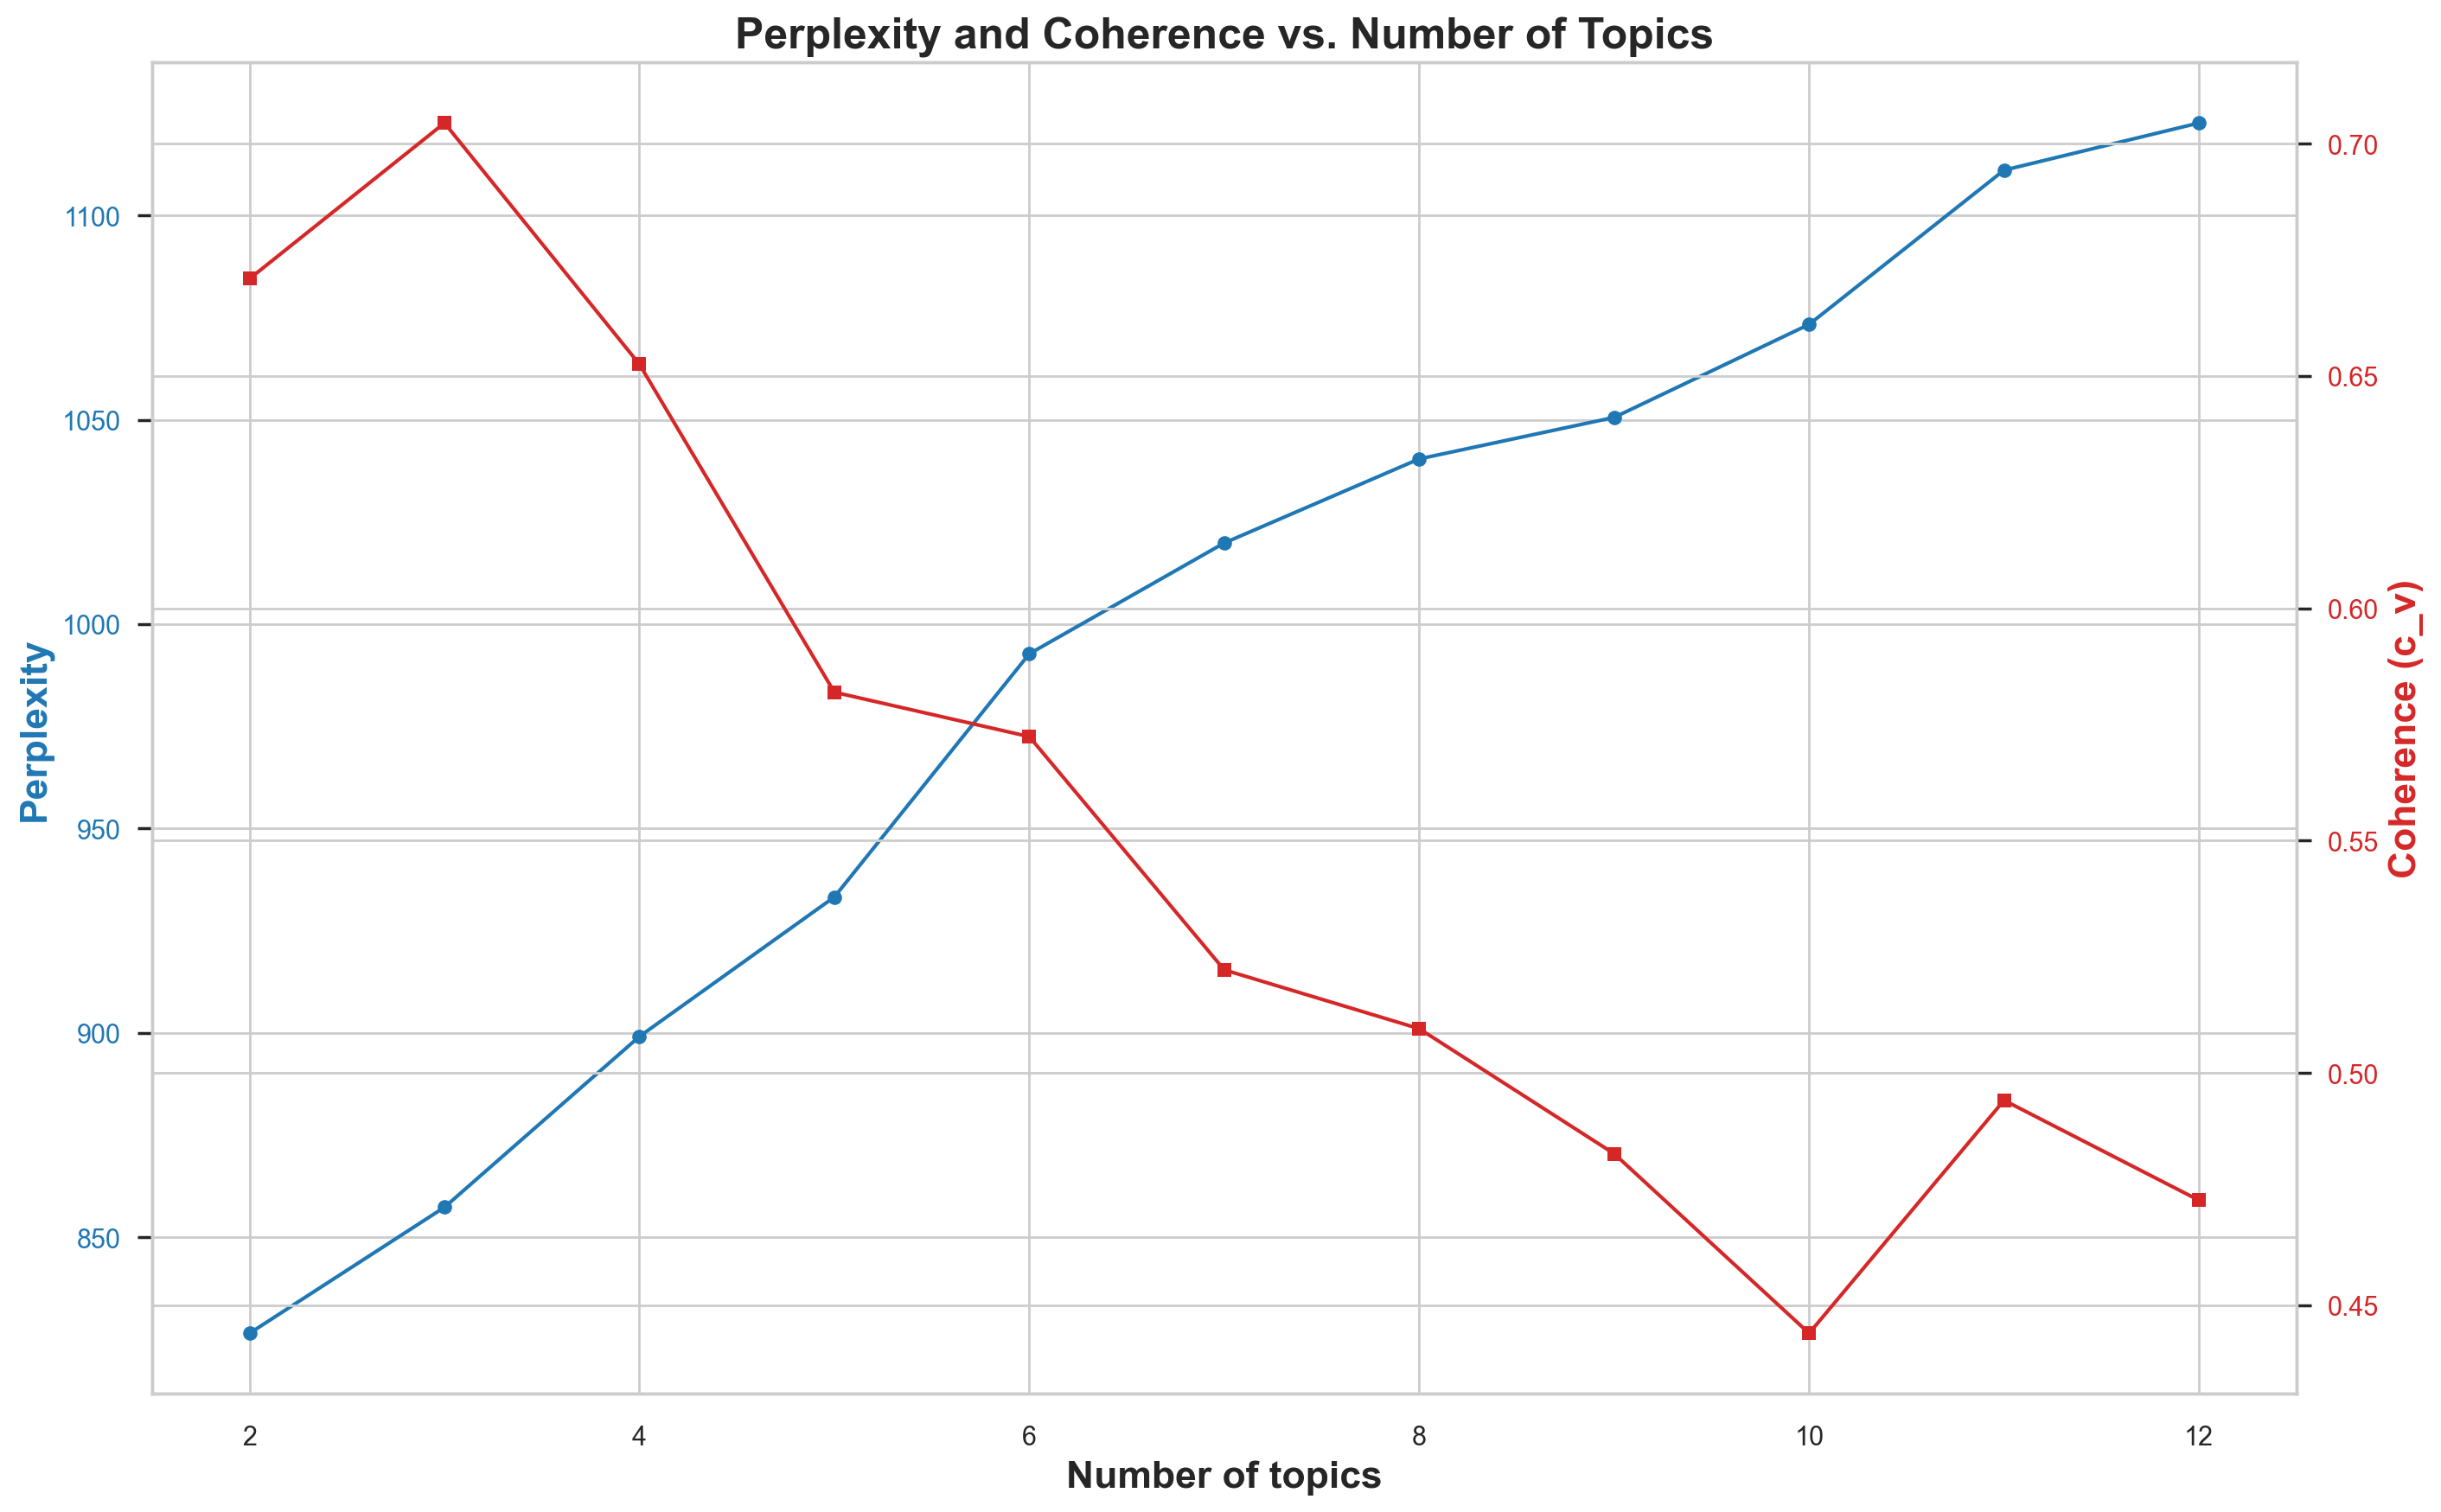

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# 1. Create a CountVectorizer
count_vec = CountVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words='english',
    lowercase=True,
    max_features=max_features
)
X = count_vec.fit_transform(corpus)
feature_names = count_vec.get_feature_names_out()

# 2. Build Gensim corpus and dictionary for coherence
texts = [doc.split() for doc in corpus]
dictionary = Dictionary(texts)
gensim_corpus = [dictionary.doc2bow(text) for text in texts]

# 3. Sweep over number of topics
topic_range = range(2, 13)   # try from 2 up to 12 topics
perplexities = []
coherence_scores = []

for k in topic_range:
    # fit sklearn LDA
    lda = LatentDirichletAllocation(
        n_components=k,
        max_iter=max_iter,
        random_state=seed_value,
        learning_method='online' # for large datasets
    ).fit(X)

    # 3a. record perplexity (lower = better fit of model to data)
    perplexities.append(lda.perplexity(X))

    # 3b. extract top-words per topic for coherence
    topics = []
    for comp in lda.components_:
        top_indices = comp.argsort()[:-10-1:-1]        # top-10 words
        topics.append([feature_names[i] for i in top_indices])

    # 3c. compute c_v coherence
    cm = CoherenceModel(
        topics=topics,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_scores.append(cm.get_coherence())

# 4. Plot both metrics
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(topic_range, perplexities, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coherence (c_v)', color=color)
ax2.plot(topic_range, coherence_scores, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Perplexity and Coherence vs. Number of Topics')
plt.show()


In [23]:
# Fitting CountVectorizer to the corpus
topic_fit_count_vec = count_vec.fit_transform(corpus)
feature_names_count = count_vec.get_feature_names_out()

# Fitting LDA model with CountVectorizer
lda_model_count_vec = base_lda_model
lda_model_count_vec.fit(topic_fit_count_vec)

# Displaying Topics for LDA model with CountVectorizer
print_topics(lda_model_count_vec, feature_names_count, n_top_words)

# Visualizing Topics for CountVectorizer using pyLDAvis
pyLDAvis.enable_notebook()
panel =  pyLDAvis.lda_model.prepare(lda_model_count_vec, topic_fit_count_vec, count_vec, mds='tsne')
pyLDAvis.display(panel)


Topic #1:
putin, russia, ukrain, trump, war, want, countri, world, nato, stop

Topic #2:
ukrain, think, use, drone, russian, tank, russia, good, territori, parad

Topic #3:
zelenski, talk, presid, way, end, peac, negoti, laugh, let, meet

Topic #4:
poland, troop, ukrain, ukrainian, nation, mean, state, western, send, ago

Topic #5:
like, russian, fight, peopl, border, usa, soldier, look, die, mani

Topic #6:
ukrain, russia, war, russian, know, video, like, militari, win, land


In [24]:
df.head(5)

videoId                                               text     type  \
0  2JsmSs3oPjc  Russia in 'far worse position now' than during...    video   
1  2JsmSs3oPjc  I only clicked to see how the bias from sky wa...  comment   
2  2JsmSs3oPjc  The Russians have moved 30 miles through heavy...  comment   
3  2JsmSs3oPjc                              I'm tired of this guy  comment   
4  2JsmSs3oPjc  Clarke is a Govt propaganda stooge from Chatha...  comment   

                                    processed_tokens  \
0  [russia, far, wors, posit, talk, michael, clar...   
1  [click, see, bia, sky, go, get, wors, fool, an...   
2  [russian, move, mile, heavi, fortif, stalem, y...   
3                                        [tire, guy]   
4  [clark, govt, propaganda, stoog, hous, make, r...   

                                 clean_text_filtered  sentiment_score  \
0  russia far wors posit talk michael clark analy...           0.2500   
1  click see bia sky go get wors fool anybodi bel...          -0.4404   
2  russian move mile heavi fortif stalem ye almos...           0.0000   
3                                           tire guy           0.0000   
4  clark govt propaganda stoog hous make ridicul ...          -0.5106   

  sentiment  
0  Positive  
1  Negative  
2   Neutral  
3   Neutral  
4  Negative

In [25]:
df.columns

Index(['videoId', 'text', 'type', 'processed_tokens', 'clean_text_filtered',
       'sentiment_score', 'sentiment'],
      dtype='object')

In [26]:
df.dtypes

videoId                 object
text                    object
type                    object
processed_tokens        object
clean_text_filtered     object
sentiment_score        float64
sentiment               object
dtype: object

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14121 entries, 0 to 14120
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   videoId              14121 non-null  object 
 1   text                 14121 non-null  object 
 2   type                 14121 non-null  object 
 3   processed_tokens     14121 non-null  object 
 4   clean_text_filtered  14121 non-null  object 
 5   sentiment_score      14121 non-null  float64
 6   sentiment            14121 non-null  object 
dtypes: float64(1), object(6)
memory usage: 772.4+ KB


In [28]:
df.describe()

sentiment_score
count     14121.000000
mean         -0.068918
std           0.424993
min          -0.998500
25%          -0.381800
50%           0.000000
75%           0.077200
max           0.997900

In [29]:
# Check null values
df.isnull().sum()

videoId                0
text                   0
type                   0
processed_tokens       0
clean_text_filtered    0
sentiment_score        0
sentiment              0
dtype: int64

In [35]:
# Count total number of comments
total_comments = df[df['type'] == 'comment'].shape[0]
print(f"Total number of comments: {total_comments}")

# Count total number of videos
total_videos = df[df['type'] == 'video'].shape[0]
print(f"Total number of videos  : {total_videos}")



Total number of comments: 14090
Total number of videos  : 31


In [37]:
# Count total number of comments per video
comments_per_video = df[df['type'] == 'comment'].groupby('videoId').size()
print(f"Total number of comments per video:")
comments_per_video

Total number of comments per video:


videoId
-YgiPmimywA      30
1S8HTZOt4Us      61
2JsmSs3oPjc     954
3-PQG9gOhXo      70
4CTei0kDQ4g     285
6dUDjbvxpMA     322
9eUQhndrFIU      47
Ej9QgA6HQYQ     497
FhSgx_IoQ-Y     932
HCLzN8Xprbk    2263
MKUoxHcGhbI     182
MyO3ObbxxeM    1052
PBajrPiEX4g     264
Qwvk1Om4cEM      17
Qyb4HZs_6ZI     118
RHk_gYw9smA     235
UMK31FF2kn0     607
WEVwY3XkTrI     867
d8Ca7PCHhMU     364
gBmUp4OvEC0      65
k7WHP9UPq24     844
kuyWr49akWg      14
lNOpwpzpvCk     228
mK7vxYdaIxU     530
mguPodqxKRs      81
rX9pEga5e5A     149
ttb3Iwx0W7c    1360
vo0ZeCI6niU     148
vzGqN89ifBI     929
wFhpVSgmm2I     128
xQao6l_y714     447
dtype: int64

In [31]:
# Save the final DataFrame to a CSV file
output_file_path = 'youtube_russiaukraine_cleaned.csv'
df.to_csv(output_file_path, index=False, encoding='utf-8')
print(f"DataFrame saved to {output_file_path}")


DataFrame saved to youtube_russiaukraine_cleaned.csv


In [42]:
import pandas as pd
import json

# Path to your JSON file
file_path = '../Data/youtube_merged_all_videos_with_comments.json'


# Load the JSON data
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Build a list of records: one 'video' row (title+description) followed by its comments
records = []
for video in data:
    vid = video.get('videoId', '')
    title = video.get('title', '')
    desc = video.get('description', '')
    channelTitle = video.get('channelTitle', '')
    videoPublishedAt = video.get('videoPublishedAt', '')
    tags = video.get('tags', [])
    viewCount = video.get('viewCount', 0)
    videoLikeCount = video.get('videoLikeCount', 0)
    videoCommentCount = video.get('videoCommentCount', 0)
    comment_count = len(video.get('comments', []))

    # First row: title + description
    records.append({
        'videoId': vid,
        'title': title,
        'description': desc,
        'channelTitle': channelTitle,
        'videoPublishedAt': videoPublishedAt,
        'tags': tags,
        'viewCount': viewCount,
        'videoLikeCount': videoLikeCount,
        'videoCommentCount': videoCommentCount,
        'text': f"{title}\n\n{desc}",
        'comment_count': comment_count,

    })
# Create DataFrame
df_of_videos = pd.DataFrame(records)


In [43]:
df_of_videos.head()

videoId                                              title  \
0  2JsmSs3oPjc  Russia in 'far worse position now' than during...   
1  lNOpwpzpvCk  Ukraine war: Putin no show at peace talks in T...   
2  4CTei0kDQ4g  Ukraine war: Russia launches attack after reje...   
3  FhSgx_IoQ-Y  Satellite images show Putin massing Russian tr...   
4  Qyb4HZs_6ZI  Abrams and Leopard vs Russian T-90M Tank in th...   

                                         description      channelTitle  \
0  Russia is in a "far worse position now" compar...          Sky News   
1  The talks in Turkey were supposed to involve t...    Channel 4 News   
2  Russia launched more than 100 Shahed and decoy...  LiveNOW from FOX   
3  Satellite images show Putin building up a subs...           The Sun   
4  Abrams and Leopard vs Russian T-90M Tank in th...            FUTURE   

       videoPublishedAt                                               tags  \
0  2025-05-16T14:37:44Z  ukraine;russia;war;conflict;analysis;professor...   
1  2025-05-15T18:33:25Z  Russia;Ukraine;Turkey;Ankara;Russia Ukraine Wa...   
2  2025-05-12T09:44:38Z  news;livenow-from-fox;video;russia;ukraine;war...   
3  2025-05-12T18:04:57Z  The Sun;news;breaking news;the sun newspaper;N...   
4  2025-05-12T11:46:59Z  tanks;ukraine news;about tanks;abrams;abrams t...   

   viewCount  videoLikeCount  videoCommentCount  \
0     392688            4944               1558   
1      59567             289                472   
2     121768             746                720   
3     365669            3029               2149   
4     290766            5098                190   

                                                text  comment_count  
0  Russia in 'far worse position now' than during...            954  
1  Ukraine war: Putin no show at peace talks in T...            228  
2  Ukraine war: Russia launches attack after reje...            285  
3  Satellite images show Putin massing Russian tr...            932  
4  Abrams and Leopard vs Russian T-90M Tank in th...            118

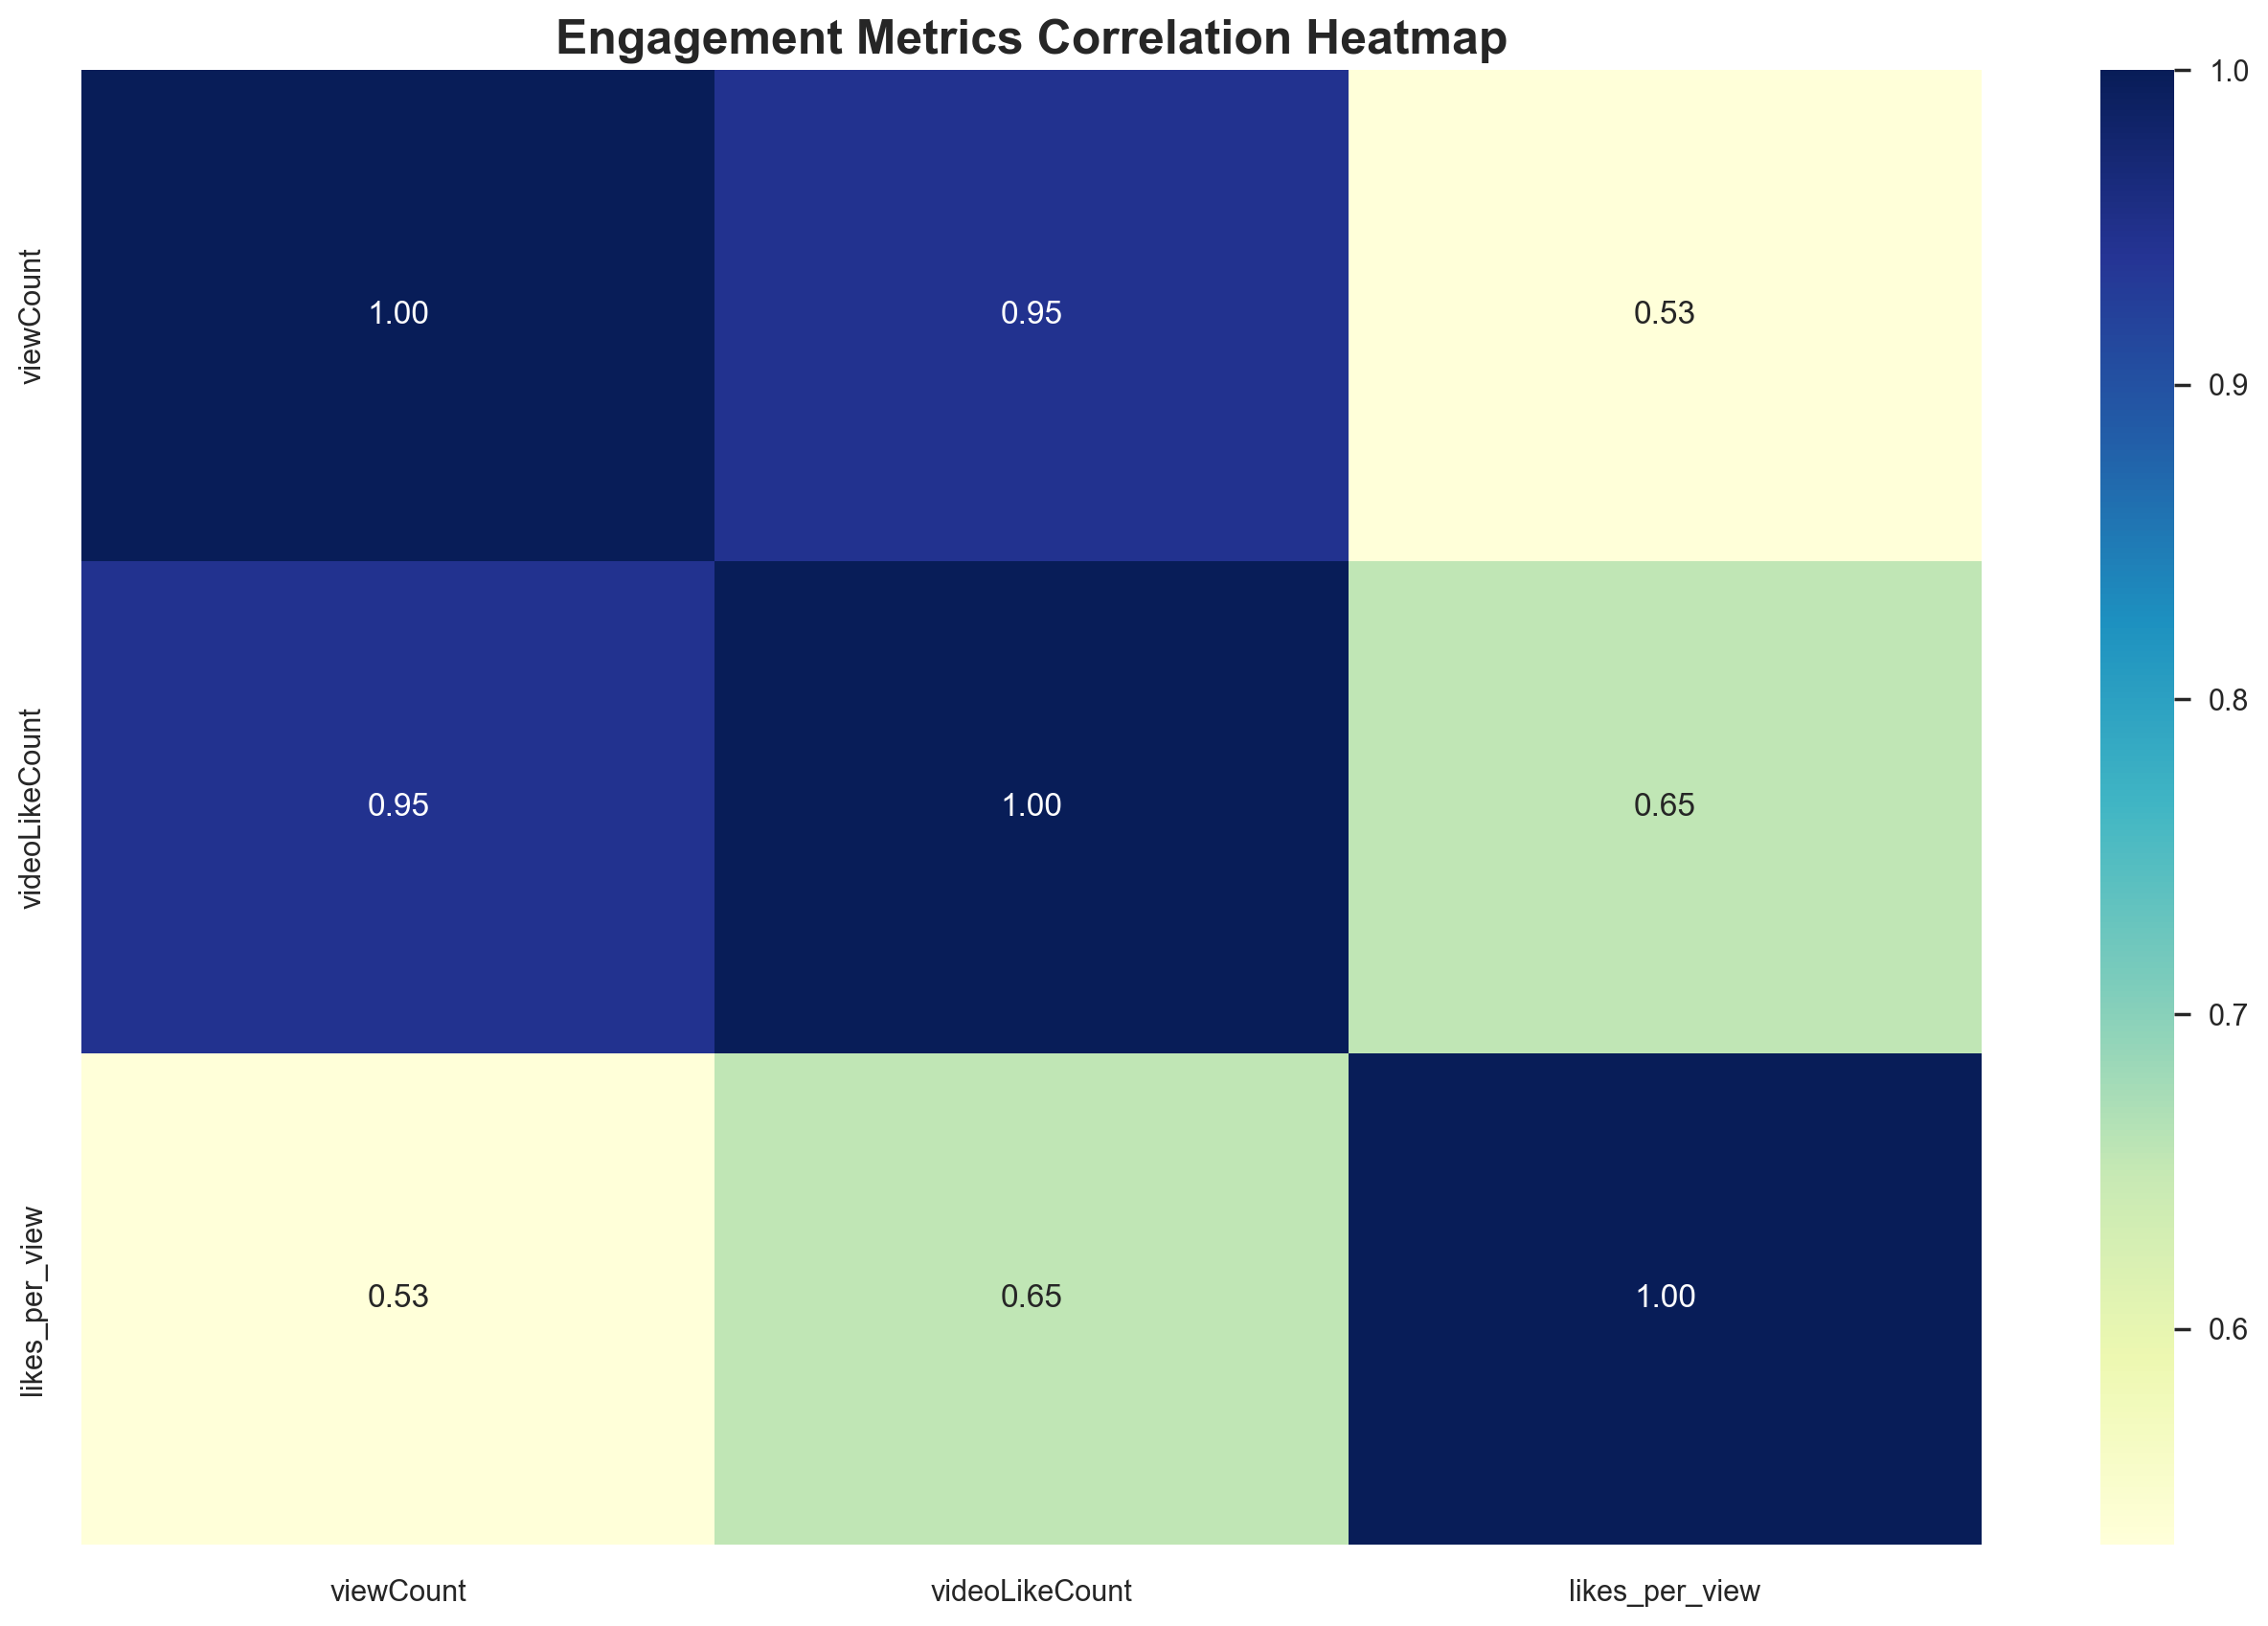

In [ ]:
# Calculate likes per view ratio
df_of_videos['likes_per_view'] = df_of_videos['videoLikeCount'] / df_of_videos['viewCount']

# plt.figure(figsize=(12, 6))
sns.heatmap(df_of_videos[['viewCount', 'videoLikeCount', 'likes_per_view']].corr(), 
            annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Engagement Metrics Correlation Heatmap')
plt.show()

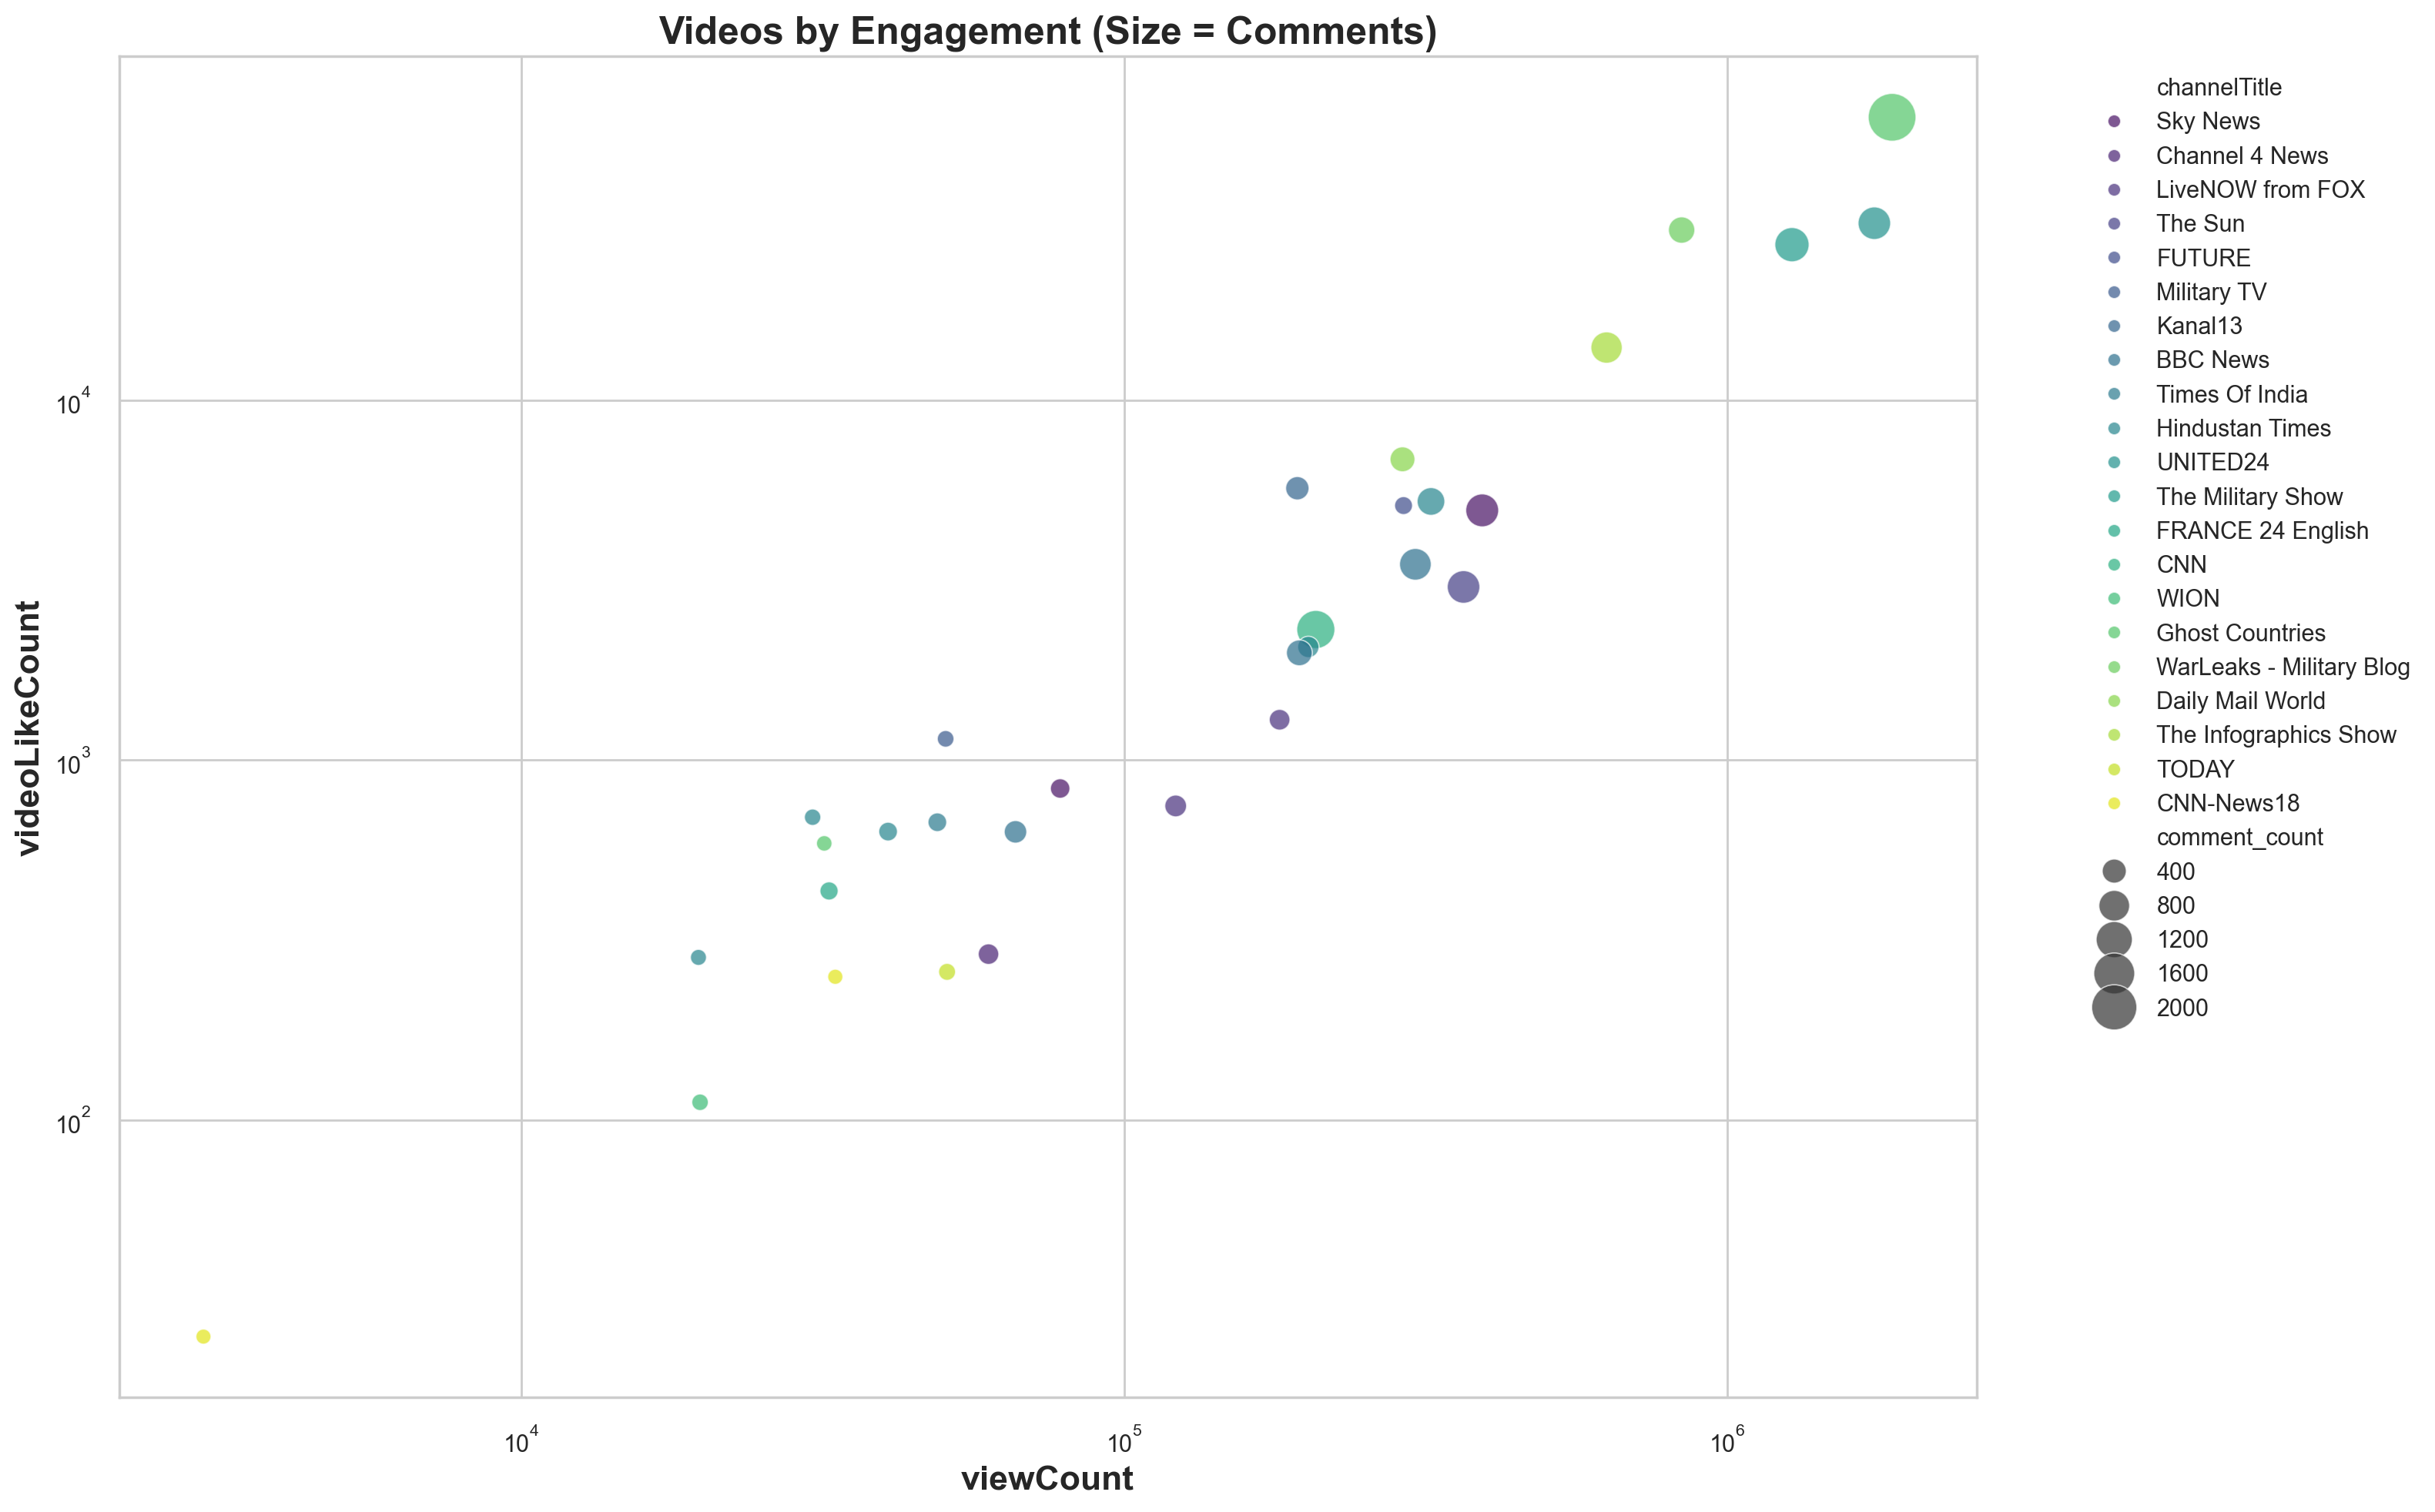

In [ ]:
sns.scatterplot(data=df_of_videos, x='viewCount', y='videoLikeCount', 
                size='comment_count', hue='channelTitle',
                sizes=(50, 500), alpha=0.7, palette='viridis')
plt.xscale('log')
plt.yscale('log')
plt.title('Videos by Engagement (Size = Comments)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

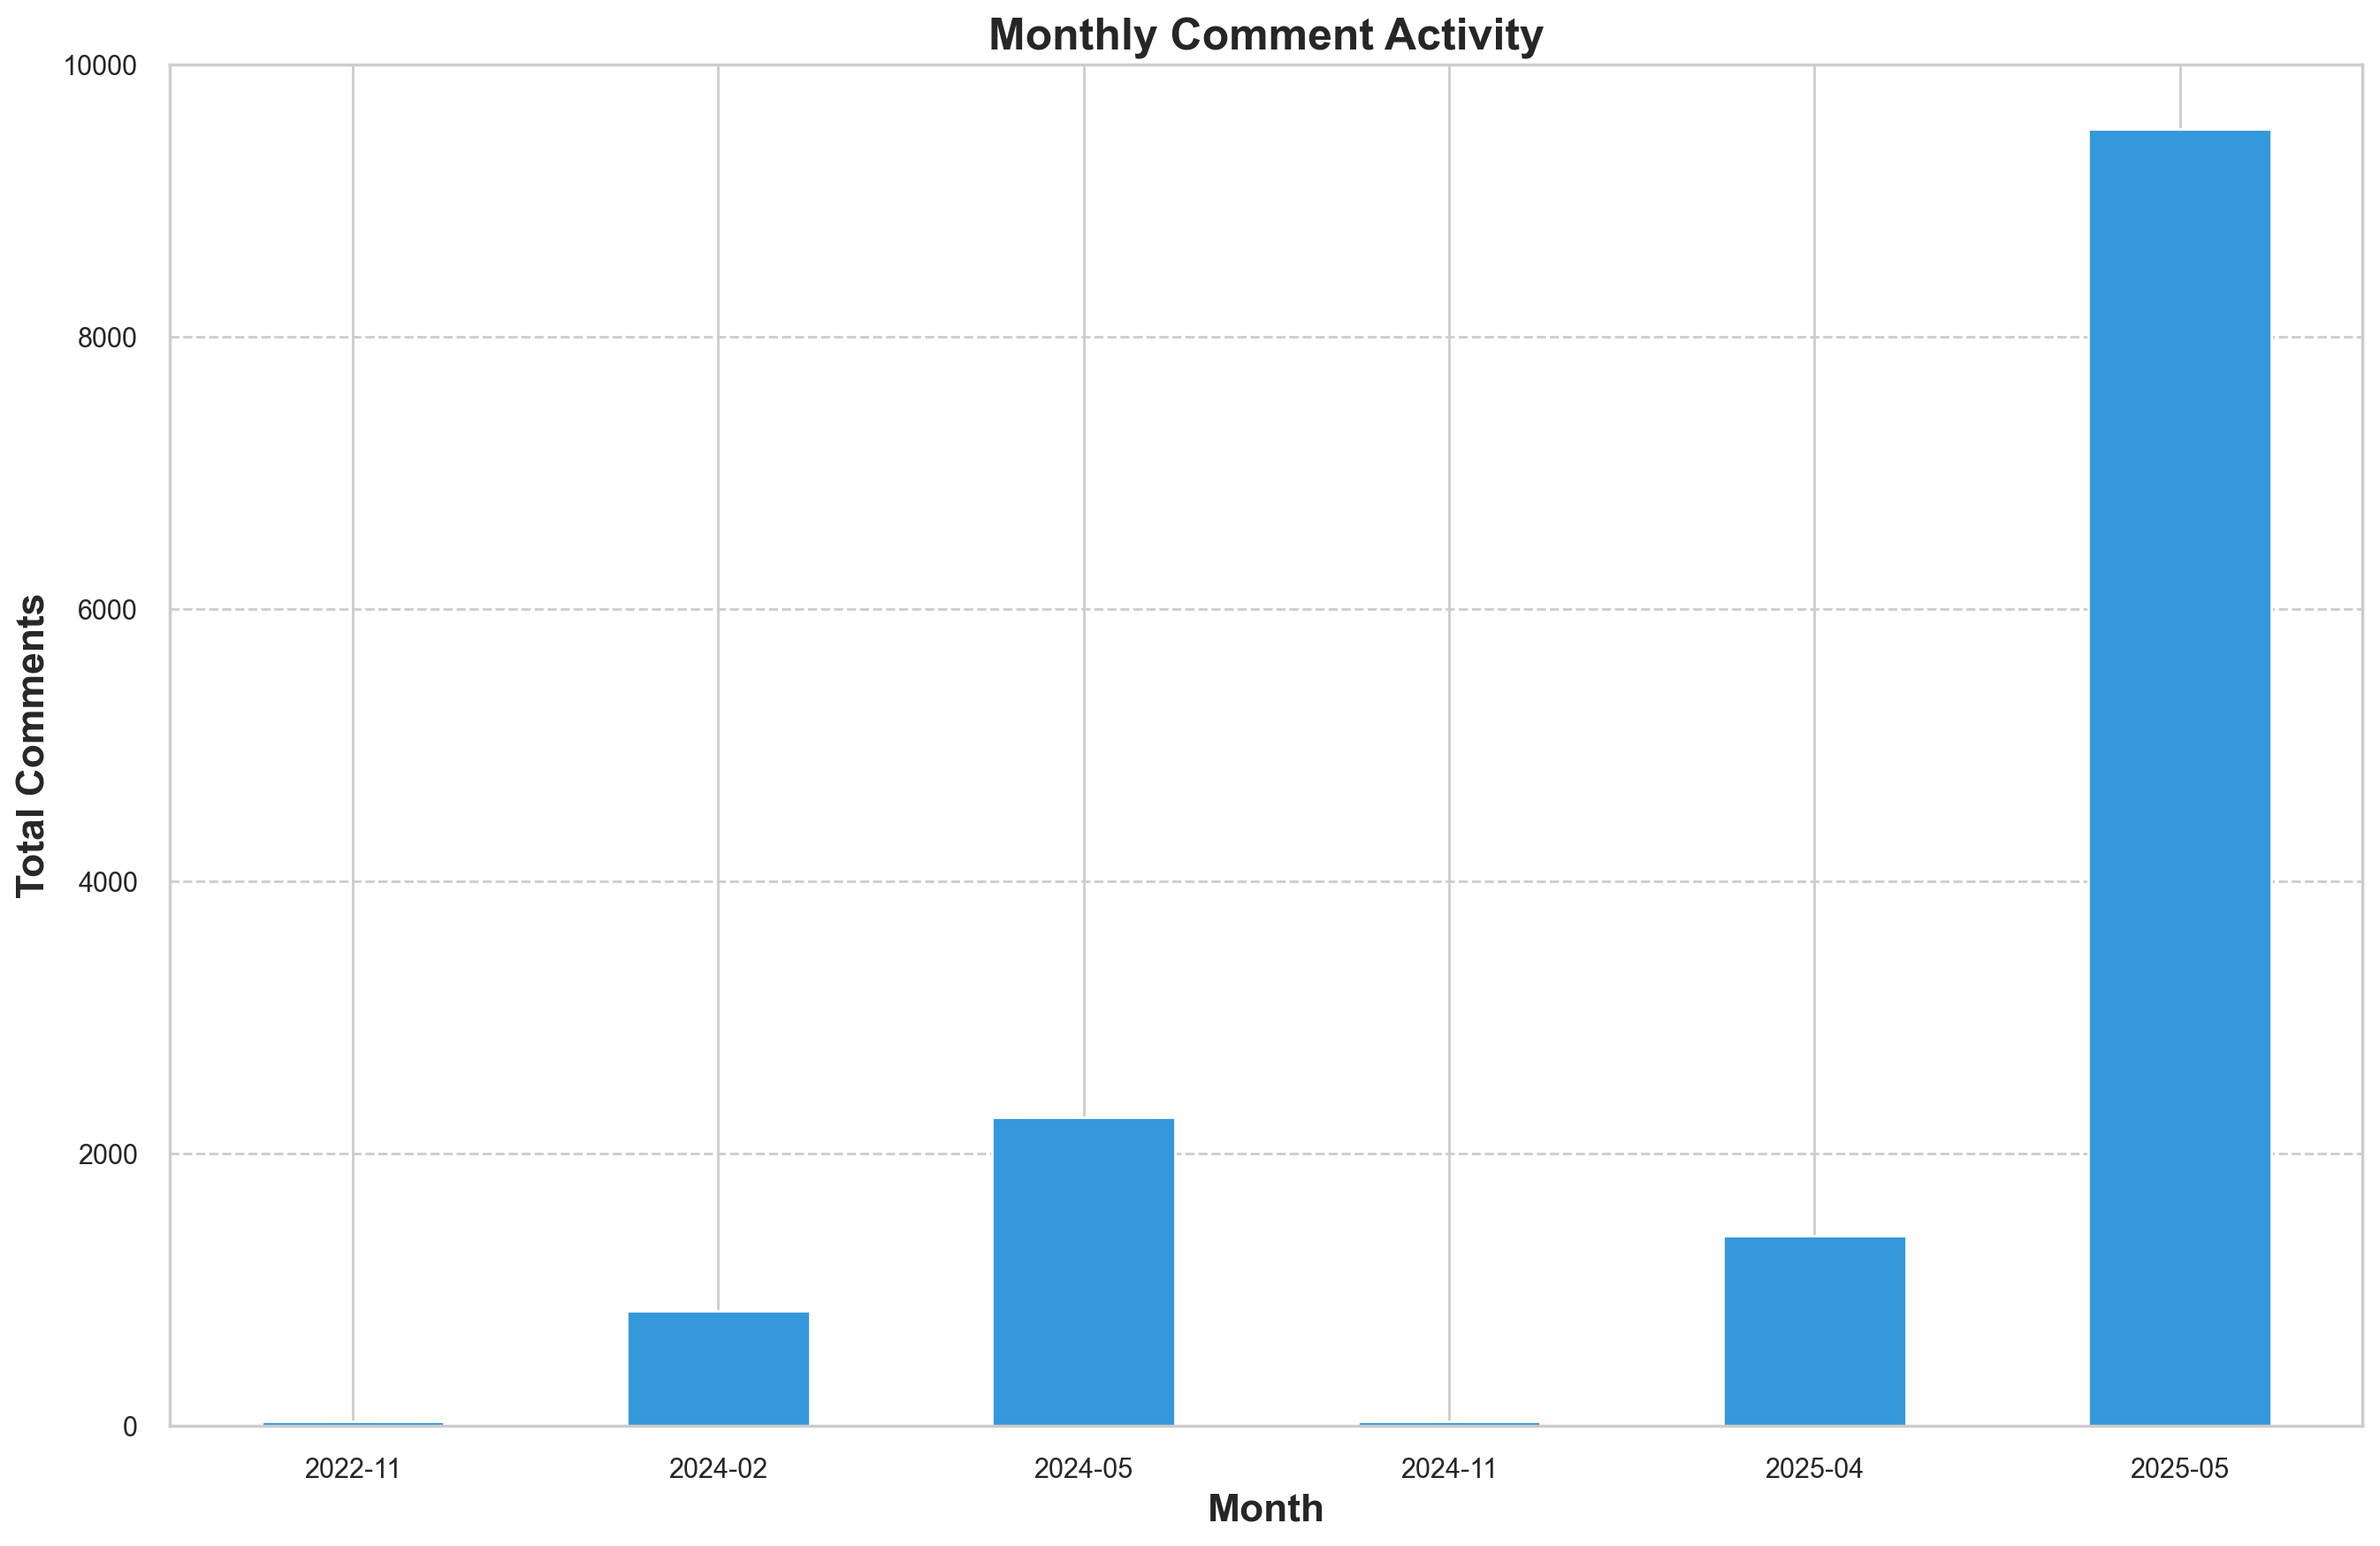

In [62]:
df_of_videos['date'] = pd.to_datetime(df_of_videos['videoPublishedAt'])
df_of_videos.groupby(df_of_videos['date'].dt.to_period('M'))['comment_count'].sum().plot(kind='bar', color='#3498db')
plt.title('Monthly Comment Activity')
plt.xlabel('Month')
plt.ylabel('Total Comments')
plt.xticks(rotation=360)
plt.grid(axis='y', linestyle='--')

Text(0.5, 1.0, 'Most Frequent Tags in Videos')

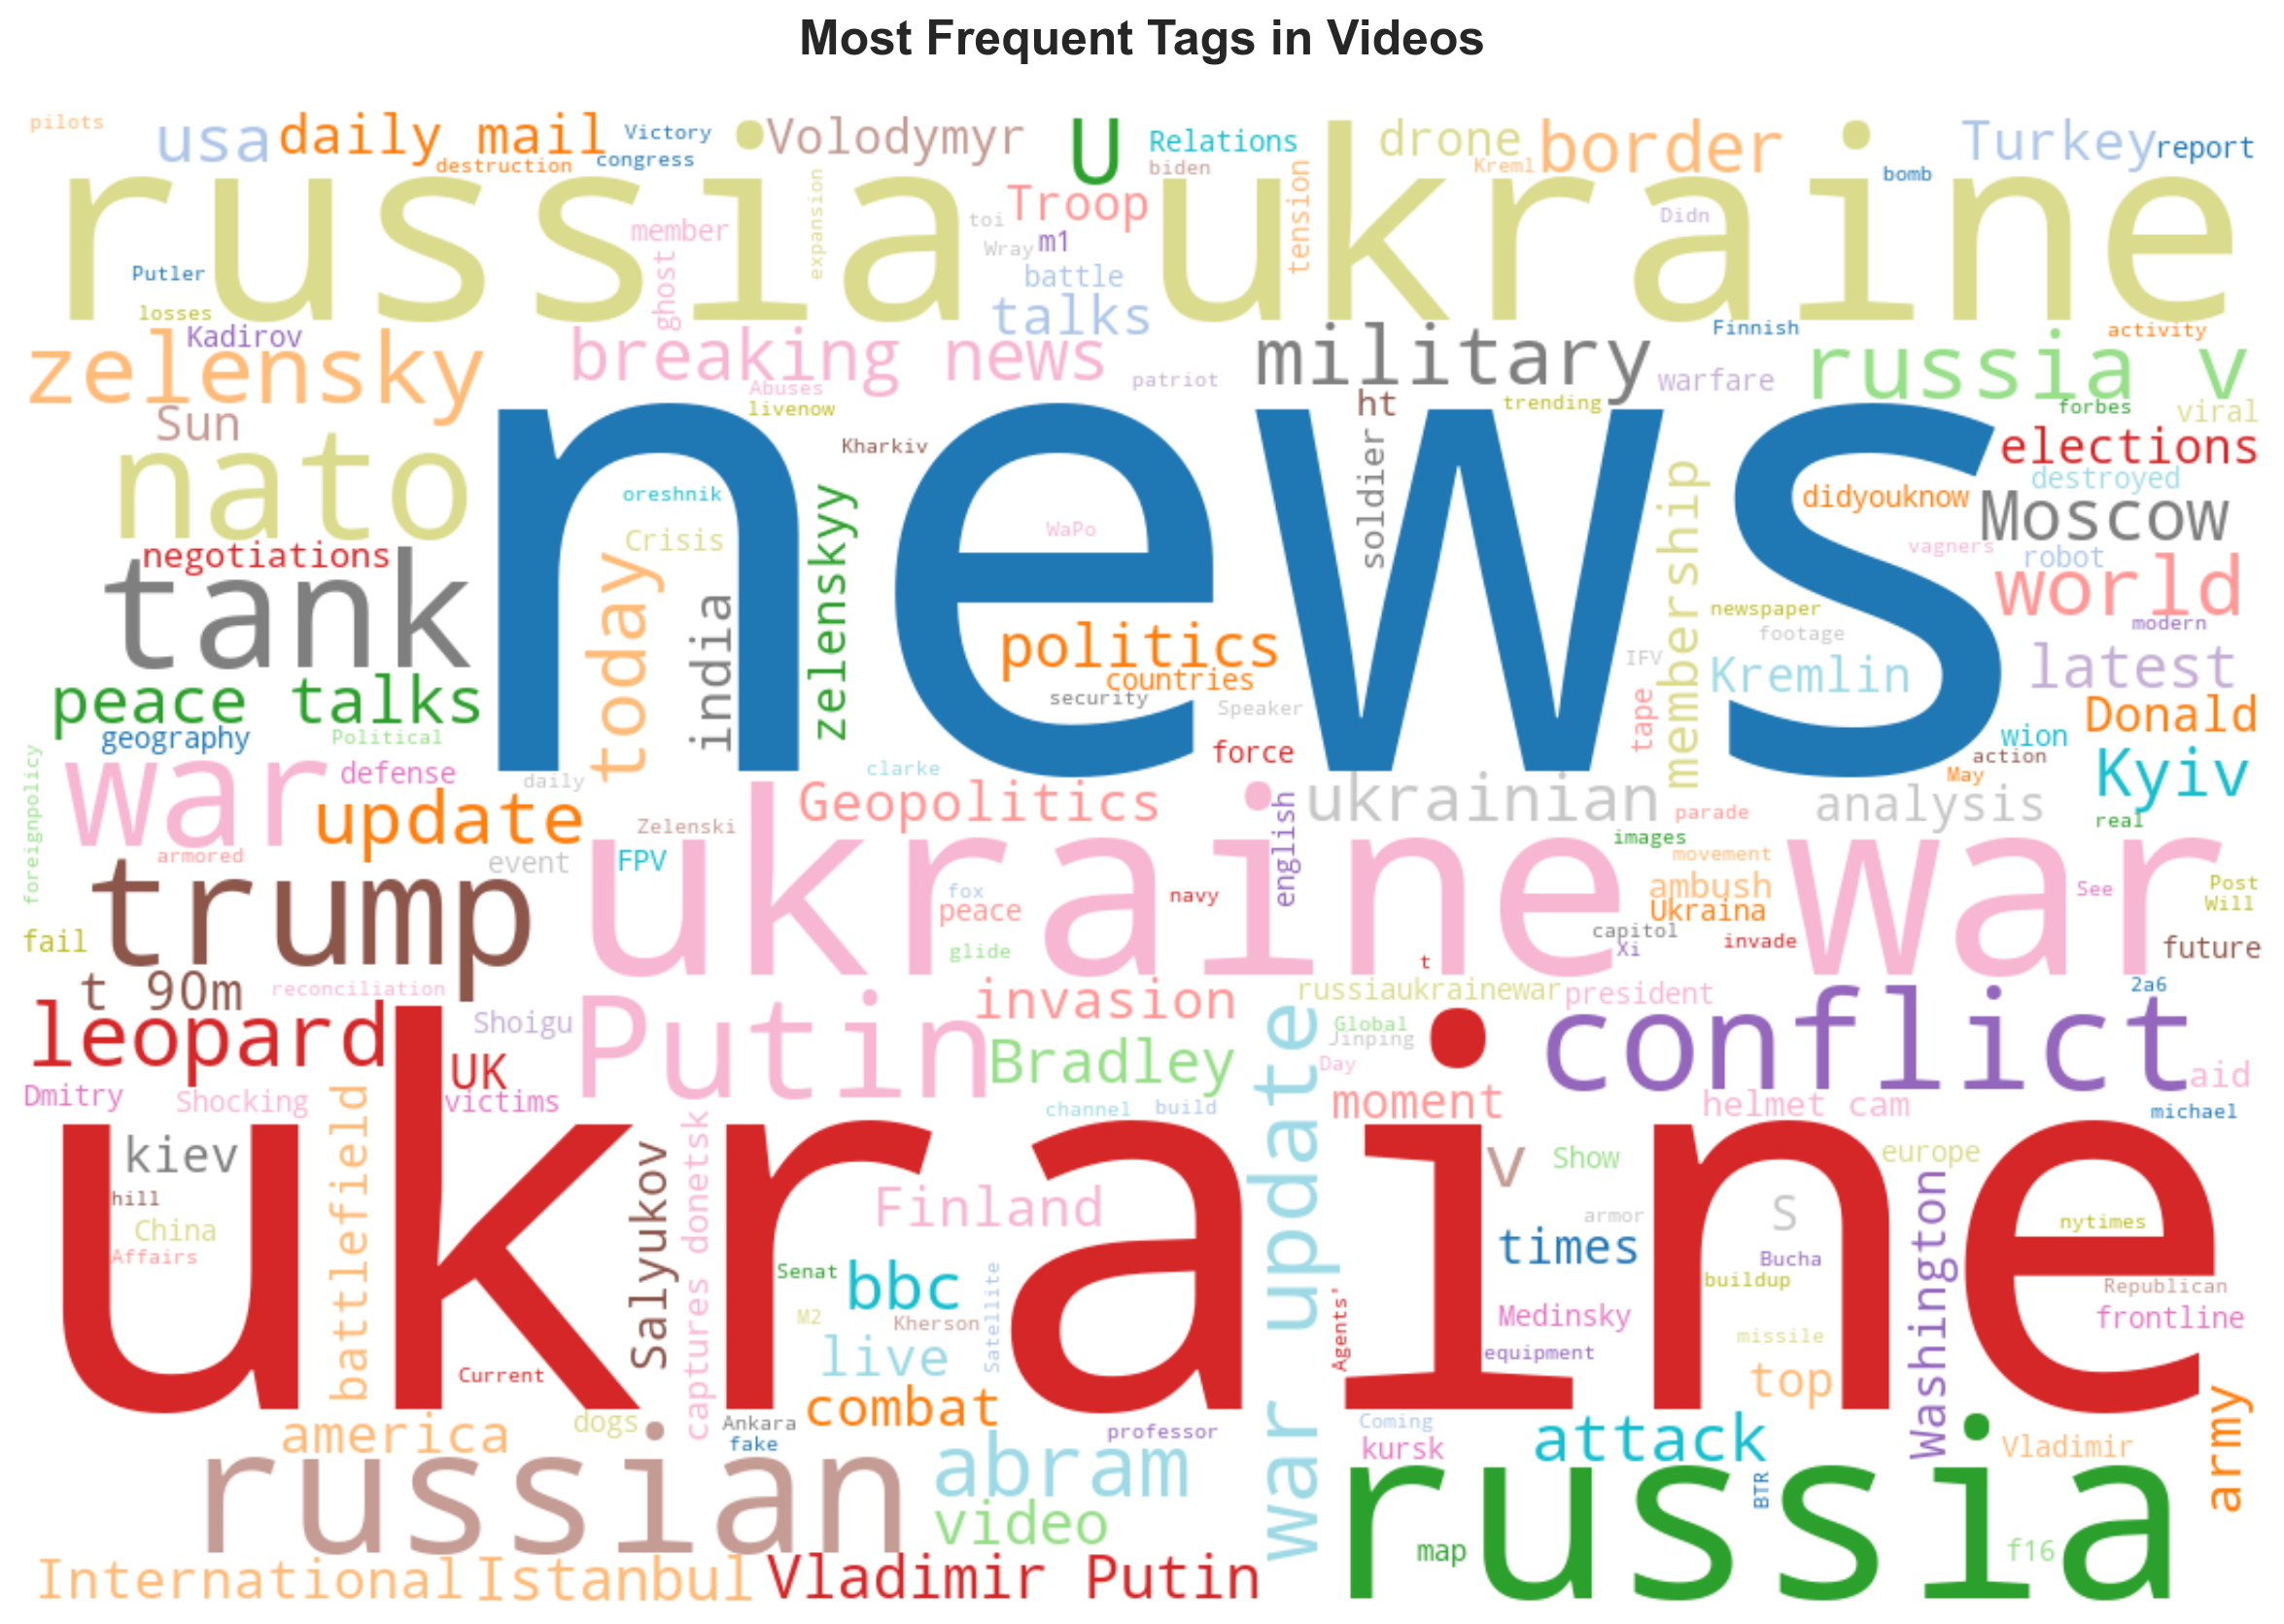

In [51]:
from wordcloud import WordCloud

tags_text = ' '.join(df_of_videos['tags'].dropna())
wordcloud = WordCloud(width=1080, height=720, 
                      background_color='white', colormap='tab20').generate(tags_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Tags in Videos', pad=20)

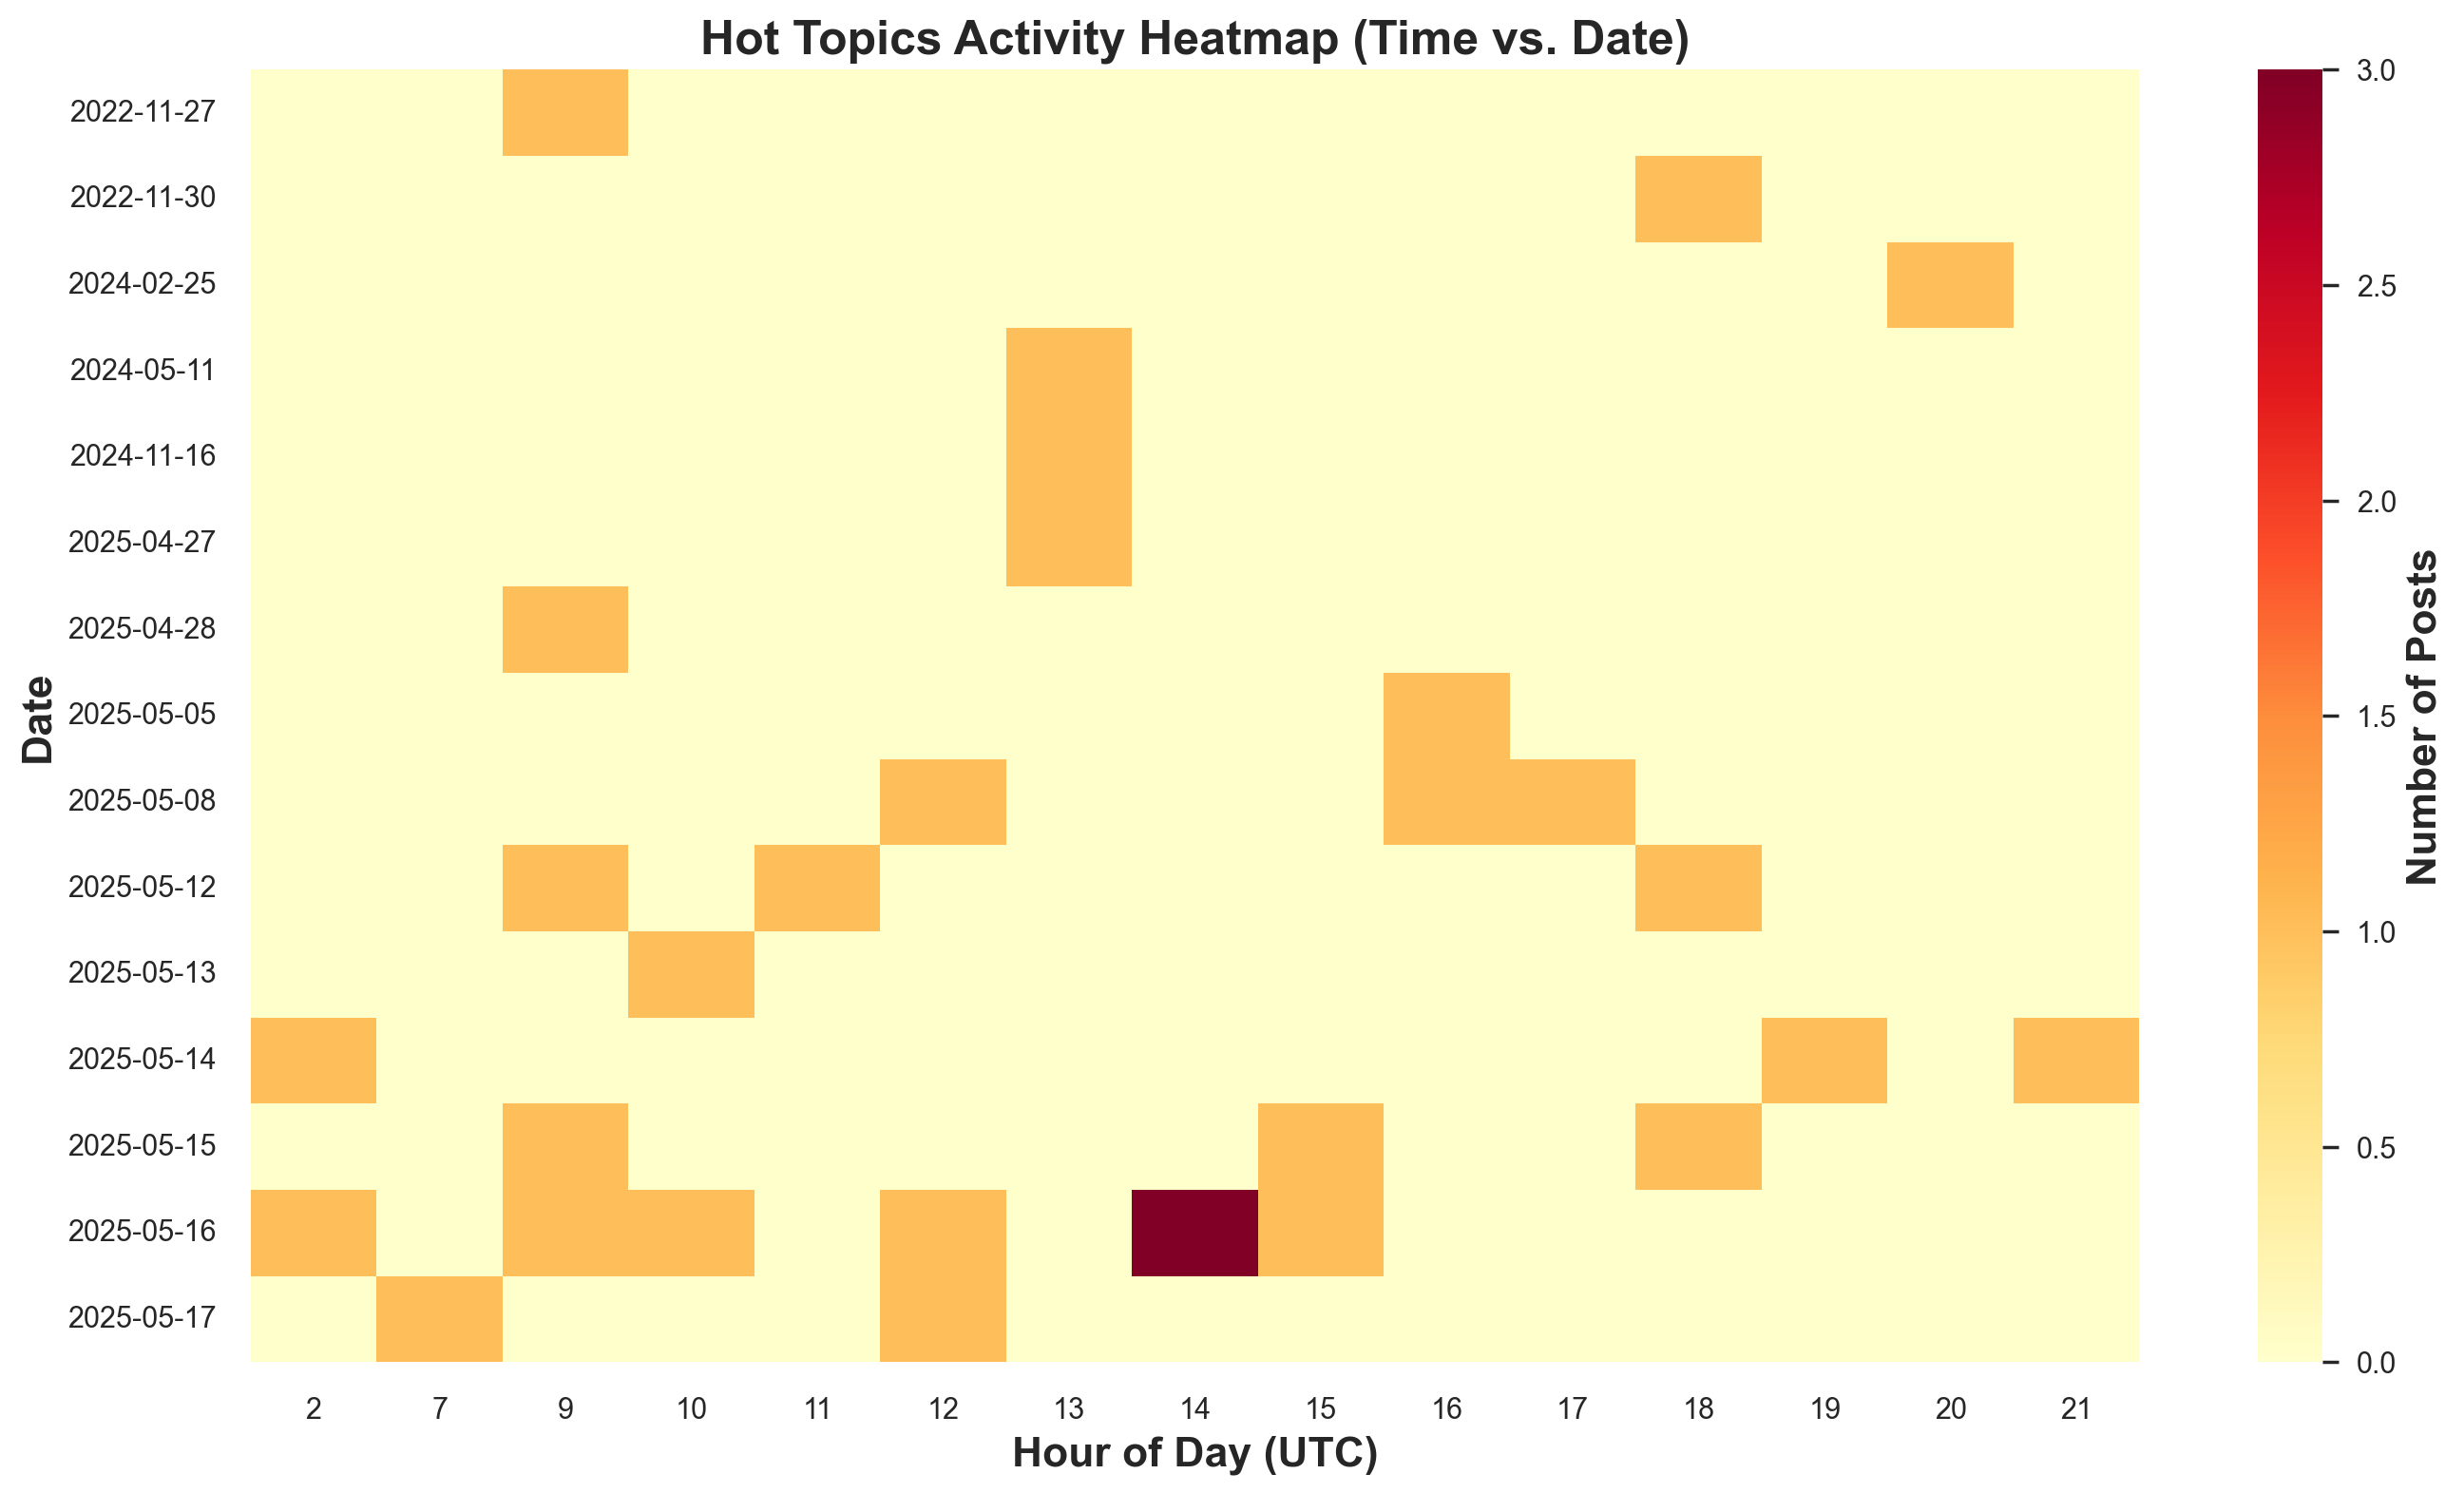

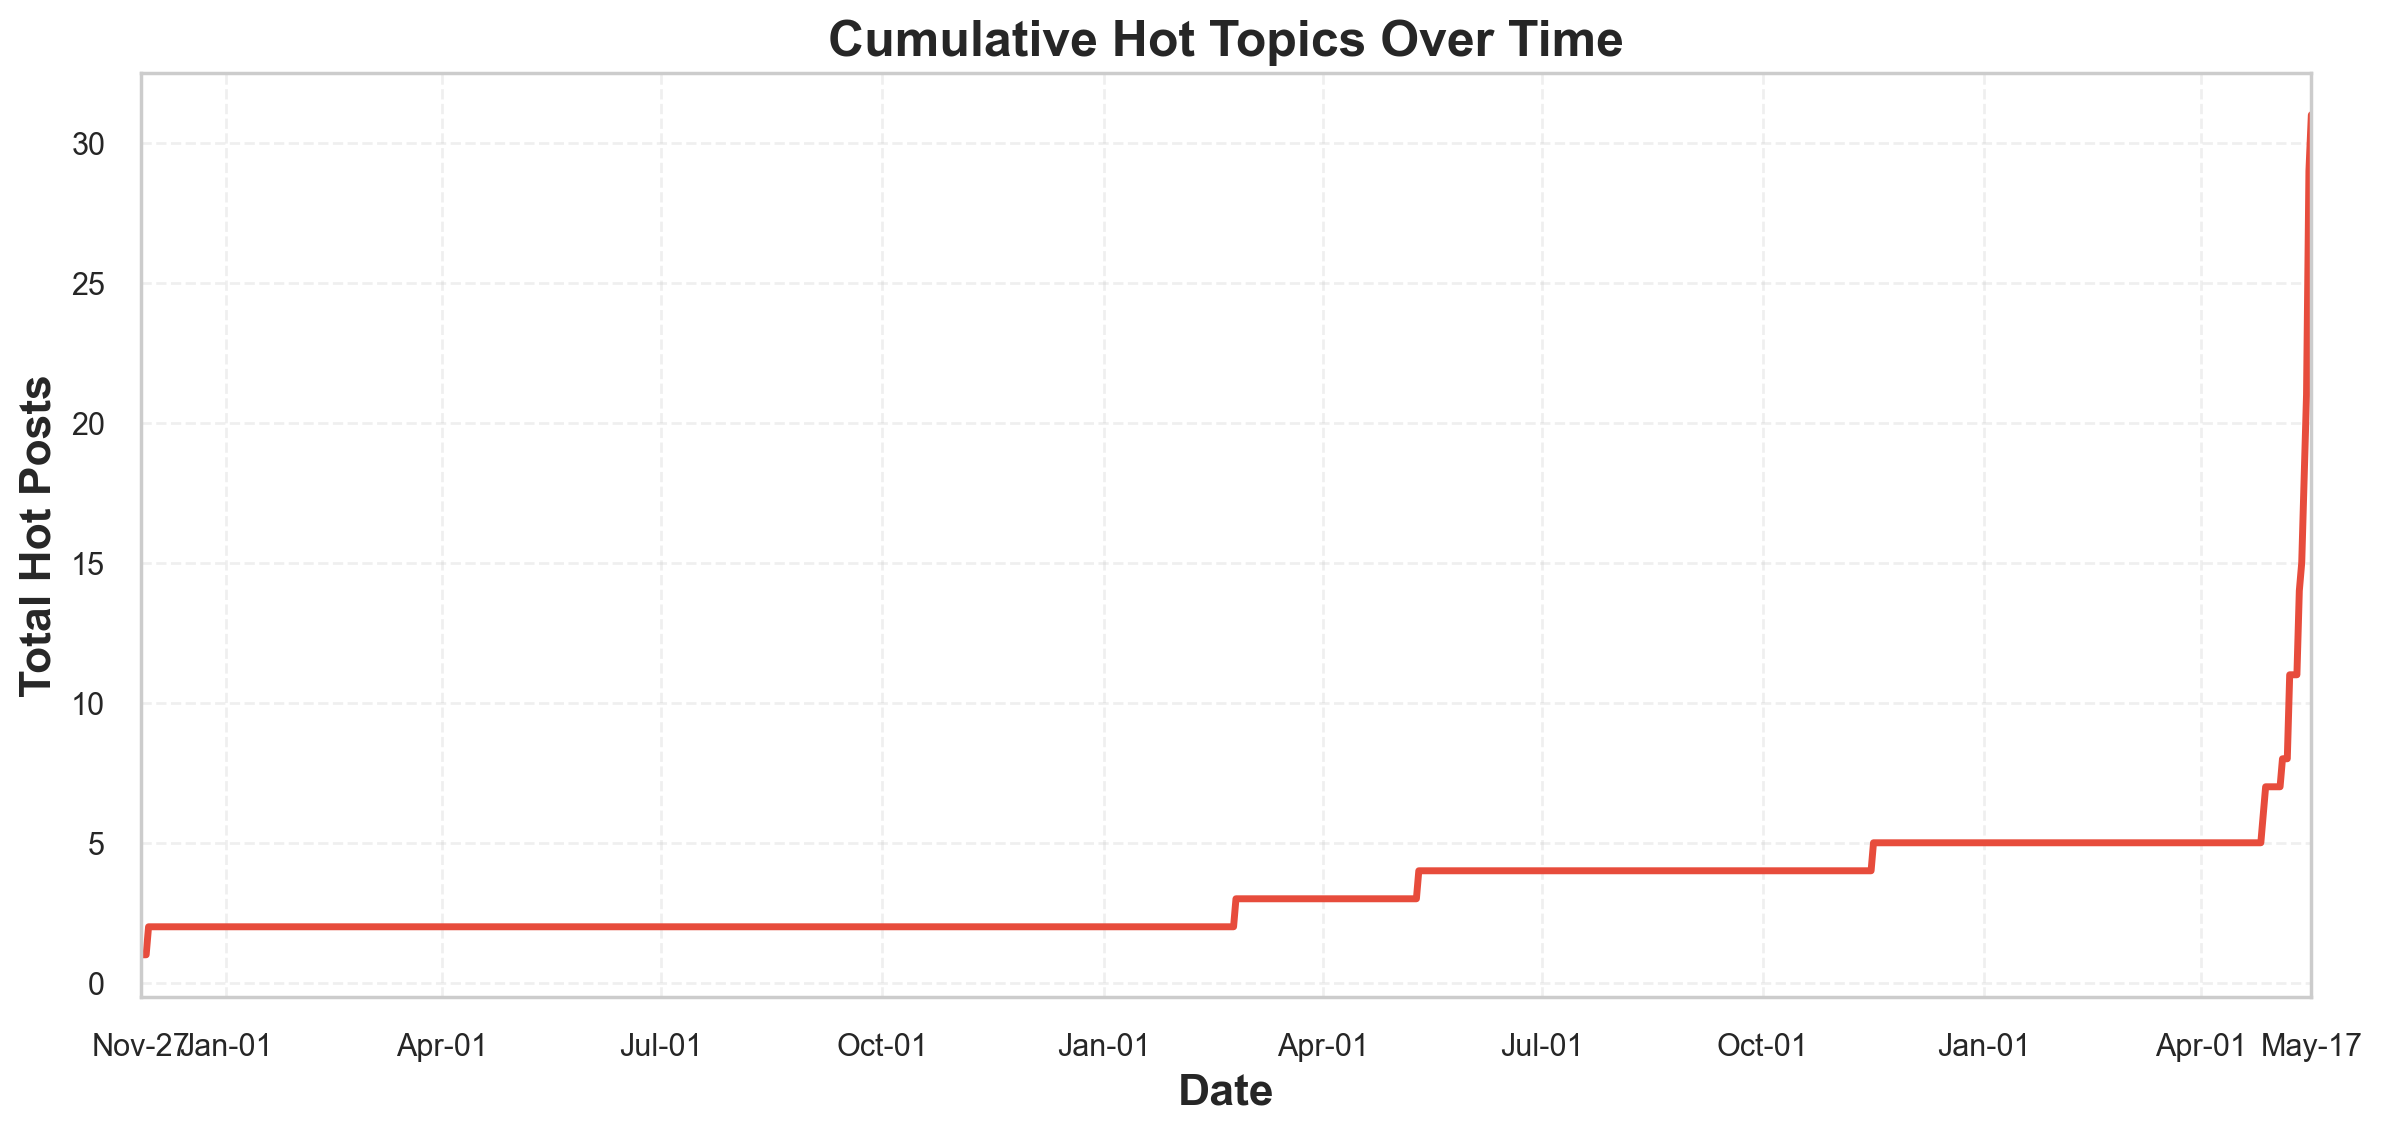

In [56]:

from matplotlib.dates import DateFormatter

# Convert timestamp
df_of_videos['datetime'] = pd.to_datetime(df_of_videos['videoPublishedAt'])

# 1. Plot Topic Frequency Heatmap
plt.figure(figsize=(14, 8))

# Resample by day/week
daily_counts = df_of_videos.set_index('datetime').resample('D').size()

# Create heatmap data
heatmap_data = df_of_videos.assign(
    hour=df_of_videos['datetime'].dt.hour,
    date=df_of_videos['datetime'].dt.date
).pivot_table(index='date', columns='hour', values='title', aggfunc='count')

# Plot
sns.heatmap(heatmap_data.fillna(0), cmap='YlOrRd', cbar_kws={'label': 'Number of Posts'})
plt.title('Hot Topics Activity Heatmap (Time vs. Date)')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# 2. Cumulative Trend Line
plt.figure(figsize=(14, 6))
daily_counts.cumsum().plot(color='#e74c3c', linewidth=2.5)
plt.title('Cumulative Hot Topics Over Time')
plt.xlabel('Date')
plt.ylabel('Total Hot Posts')
plt.grid(True, linestyle='--', alpha=0.3)
date_form = DateFormatter("%b-%d")
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

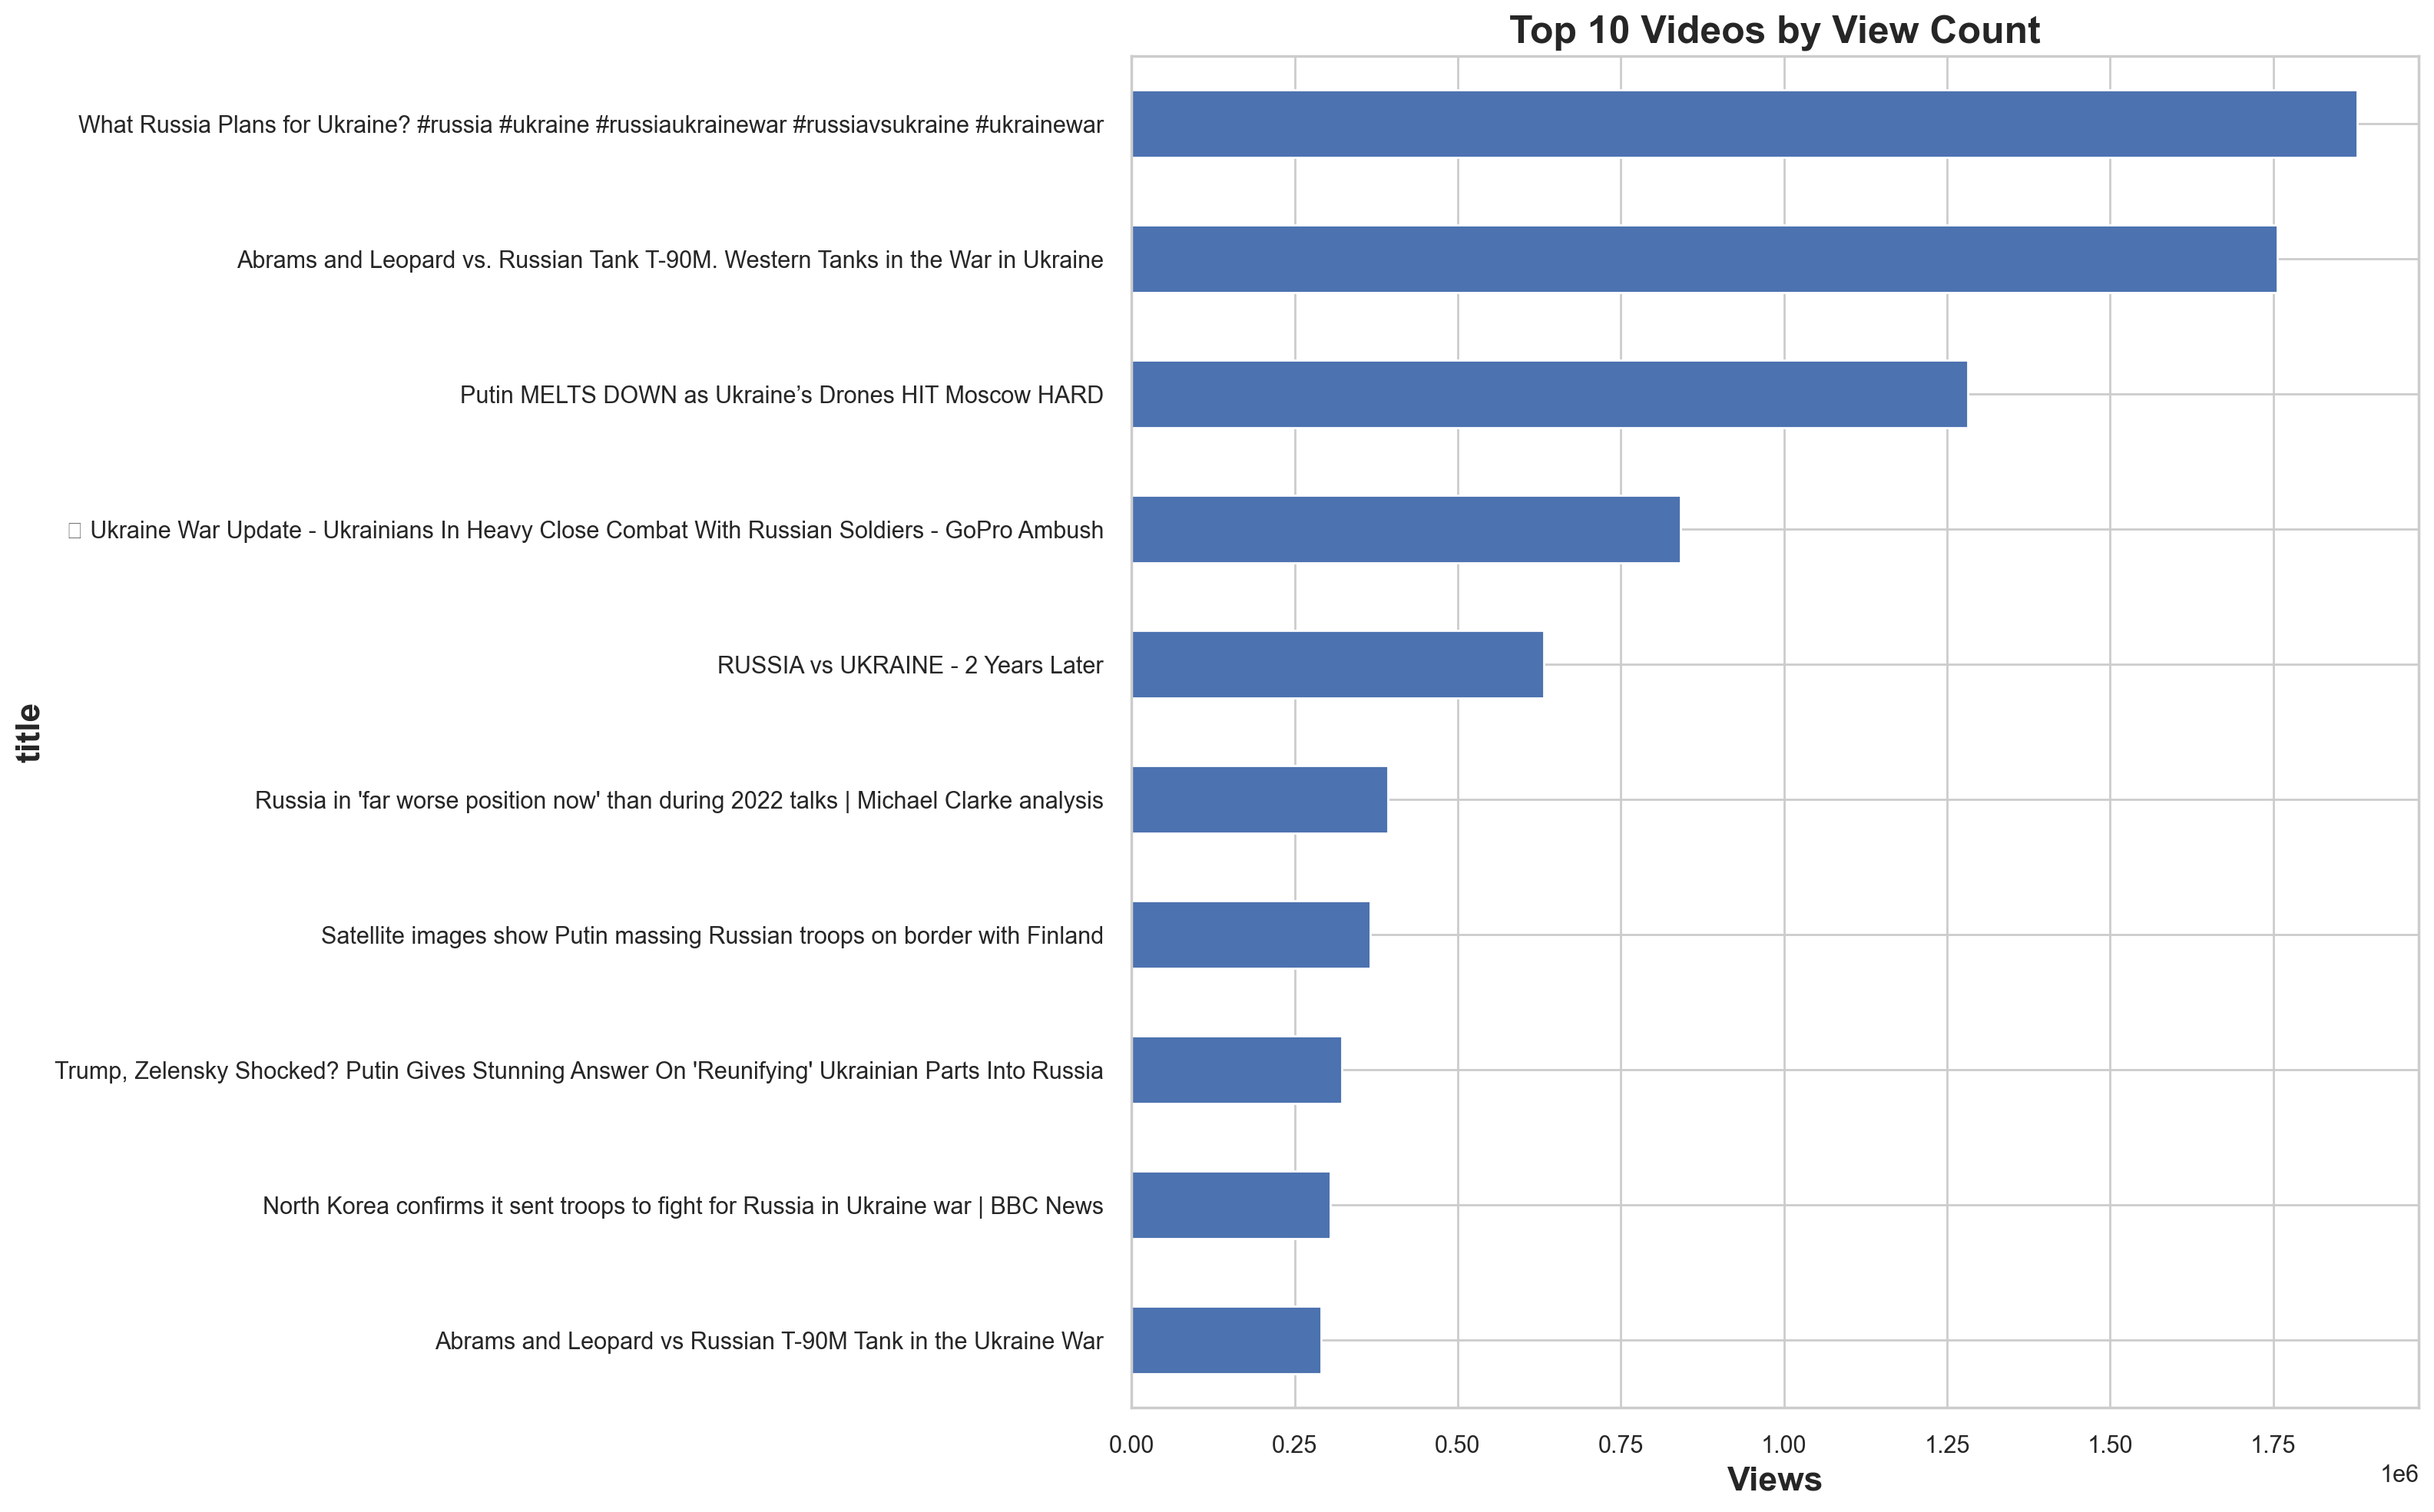

In [64]:
#########################################################
## GPT 
#########################################################



# ensure viewCount is numeric
df_of_videos['viewCount'] = pd.to_numeric(df_of_videos['viewCount'], errors='coerce')

# pick top 10
top10 = (
    df_of_videos.drop_duplicates('videoId')
                .nlargest(10, 'viewCount')
                .set_index('title')['viewCount']
)

top10.sort_values().plot.barh()
plt.title("Top 10 Videos by View Count")
plt.xlabel("Views")
plt.tight_layout()
plt.show()


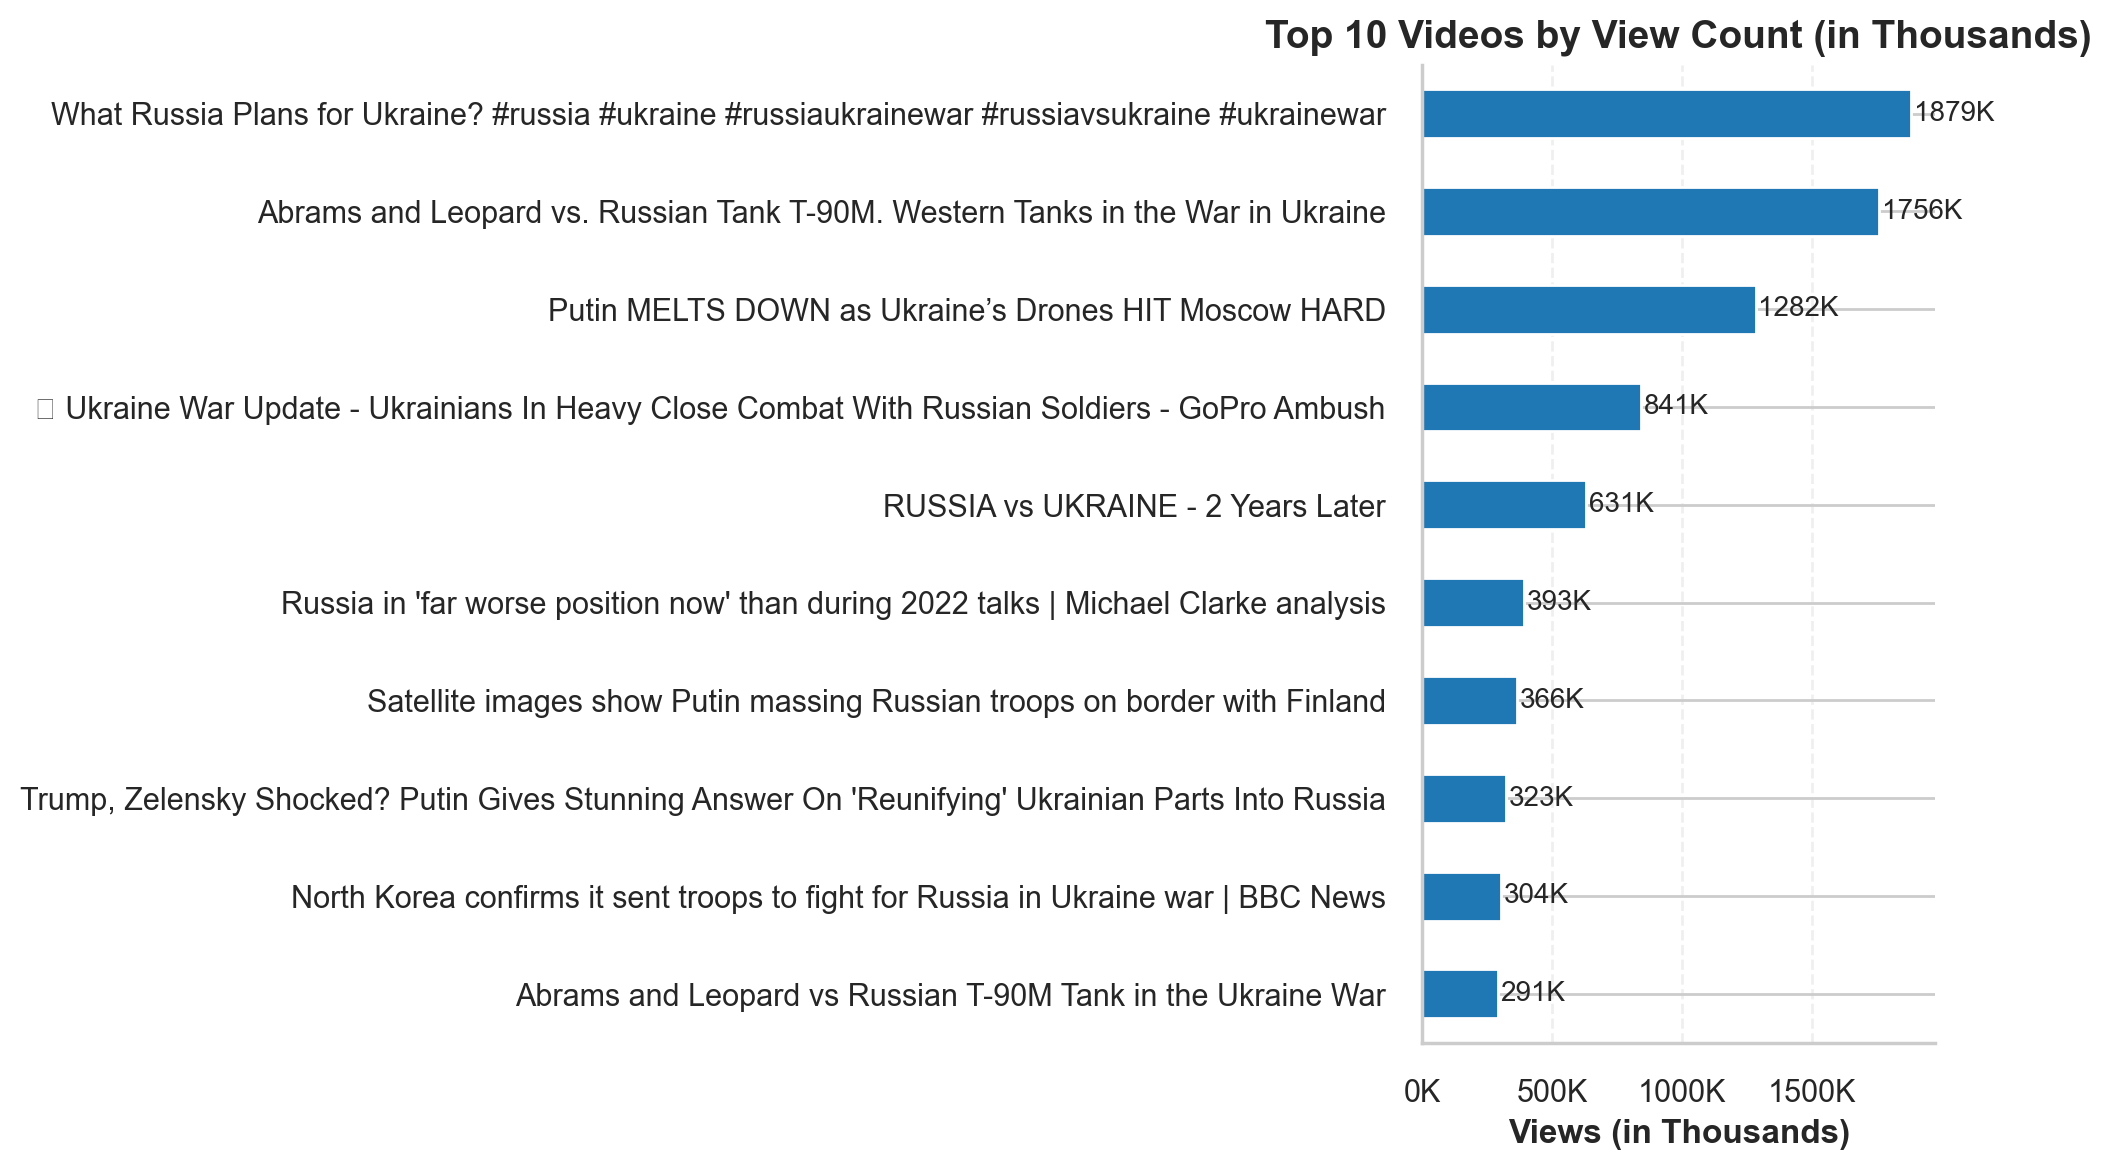

In [73]:
import matplotlib.ticker as ticker
import seaborn as sns

# Convert viewCount to numeric and get top 10 videos
df_of_videos['viewCount'] = pd.to_numeric(df_of_videos['viewCount'], errors='coerce')
top10 = (
    df_of_videos.drop_duplicates('videoId')
                .nlargest(10, 'viewCount')
                .set_index('title')['viewCount']
)

# Create plot
plt.figure(figsize=(10, 6))
ax = top10.sort_values().plot.barh(color='#1f77b4')

# Format ALL numbers in thousands (K) 
def format_k(x, pos):
    return f'{x/1000:.0f}K'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_k))

# Add value labels
for i, v in enumerate(top10.sort_values()):
    ax.text(v + 10000, i, f'{v/1000:.0f}K', 
            va='center', fontsize=10)

# Style
plt.title('Top 10 Videos by View Count (in Thousands)', fontsize=14)
plt.xlabel('Views (in Thousands)', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

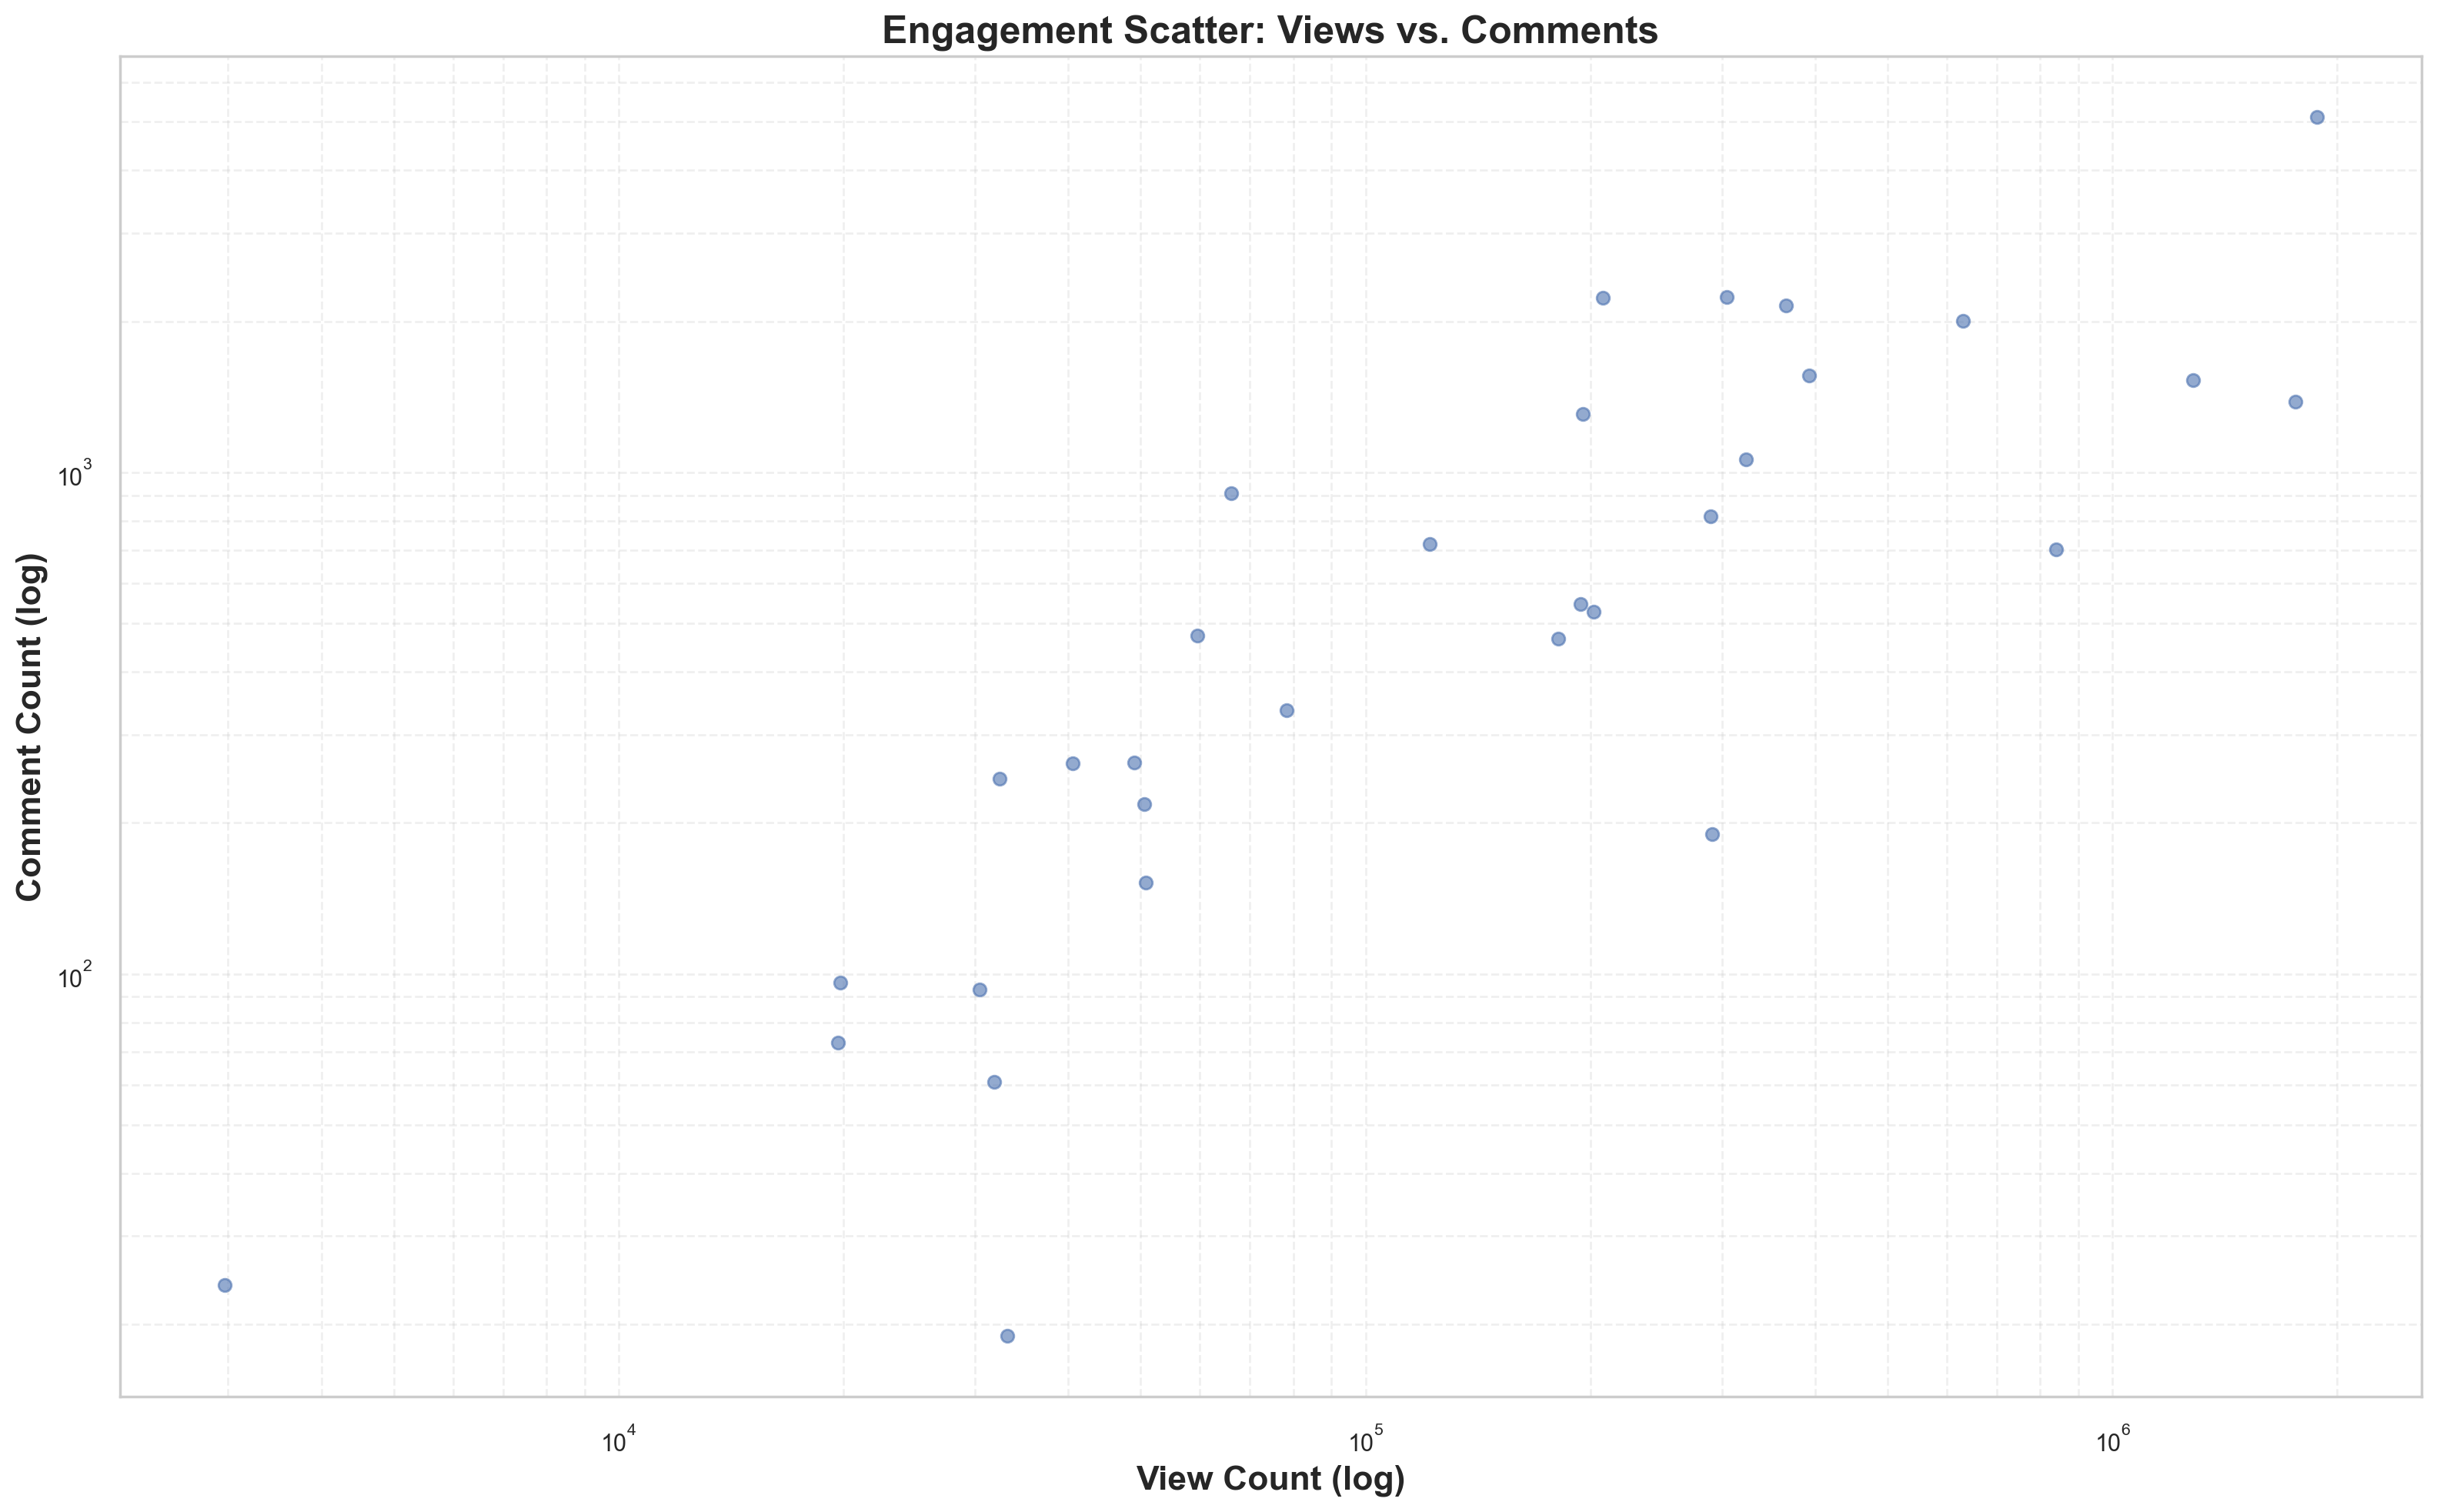

In [65]:

plt.scatter(
    df_of_videos['viewCount'],
    df_of_videos['videoCommentCount'],
    alpha=0.6
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("View Count (log)")
plt.ylabel("Comment Count (log)")
plt.title("Engagement Scatter: Views vs. Comments")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.show()


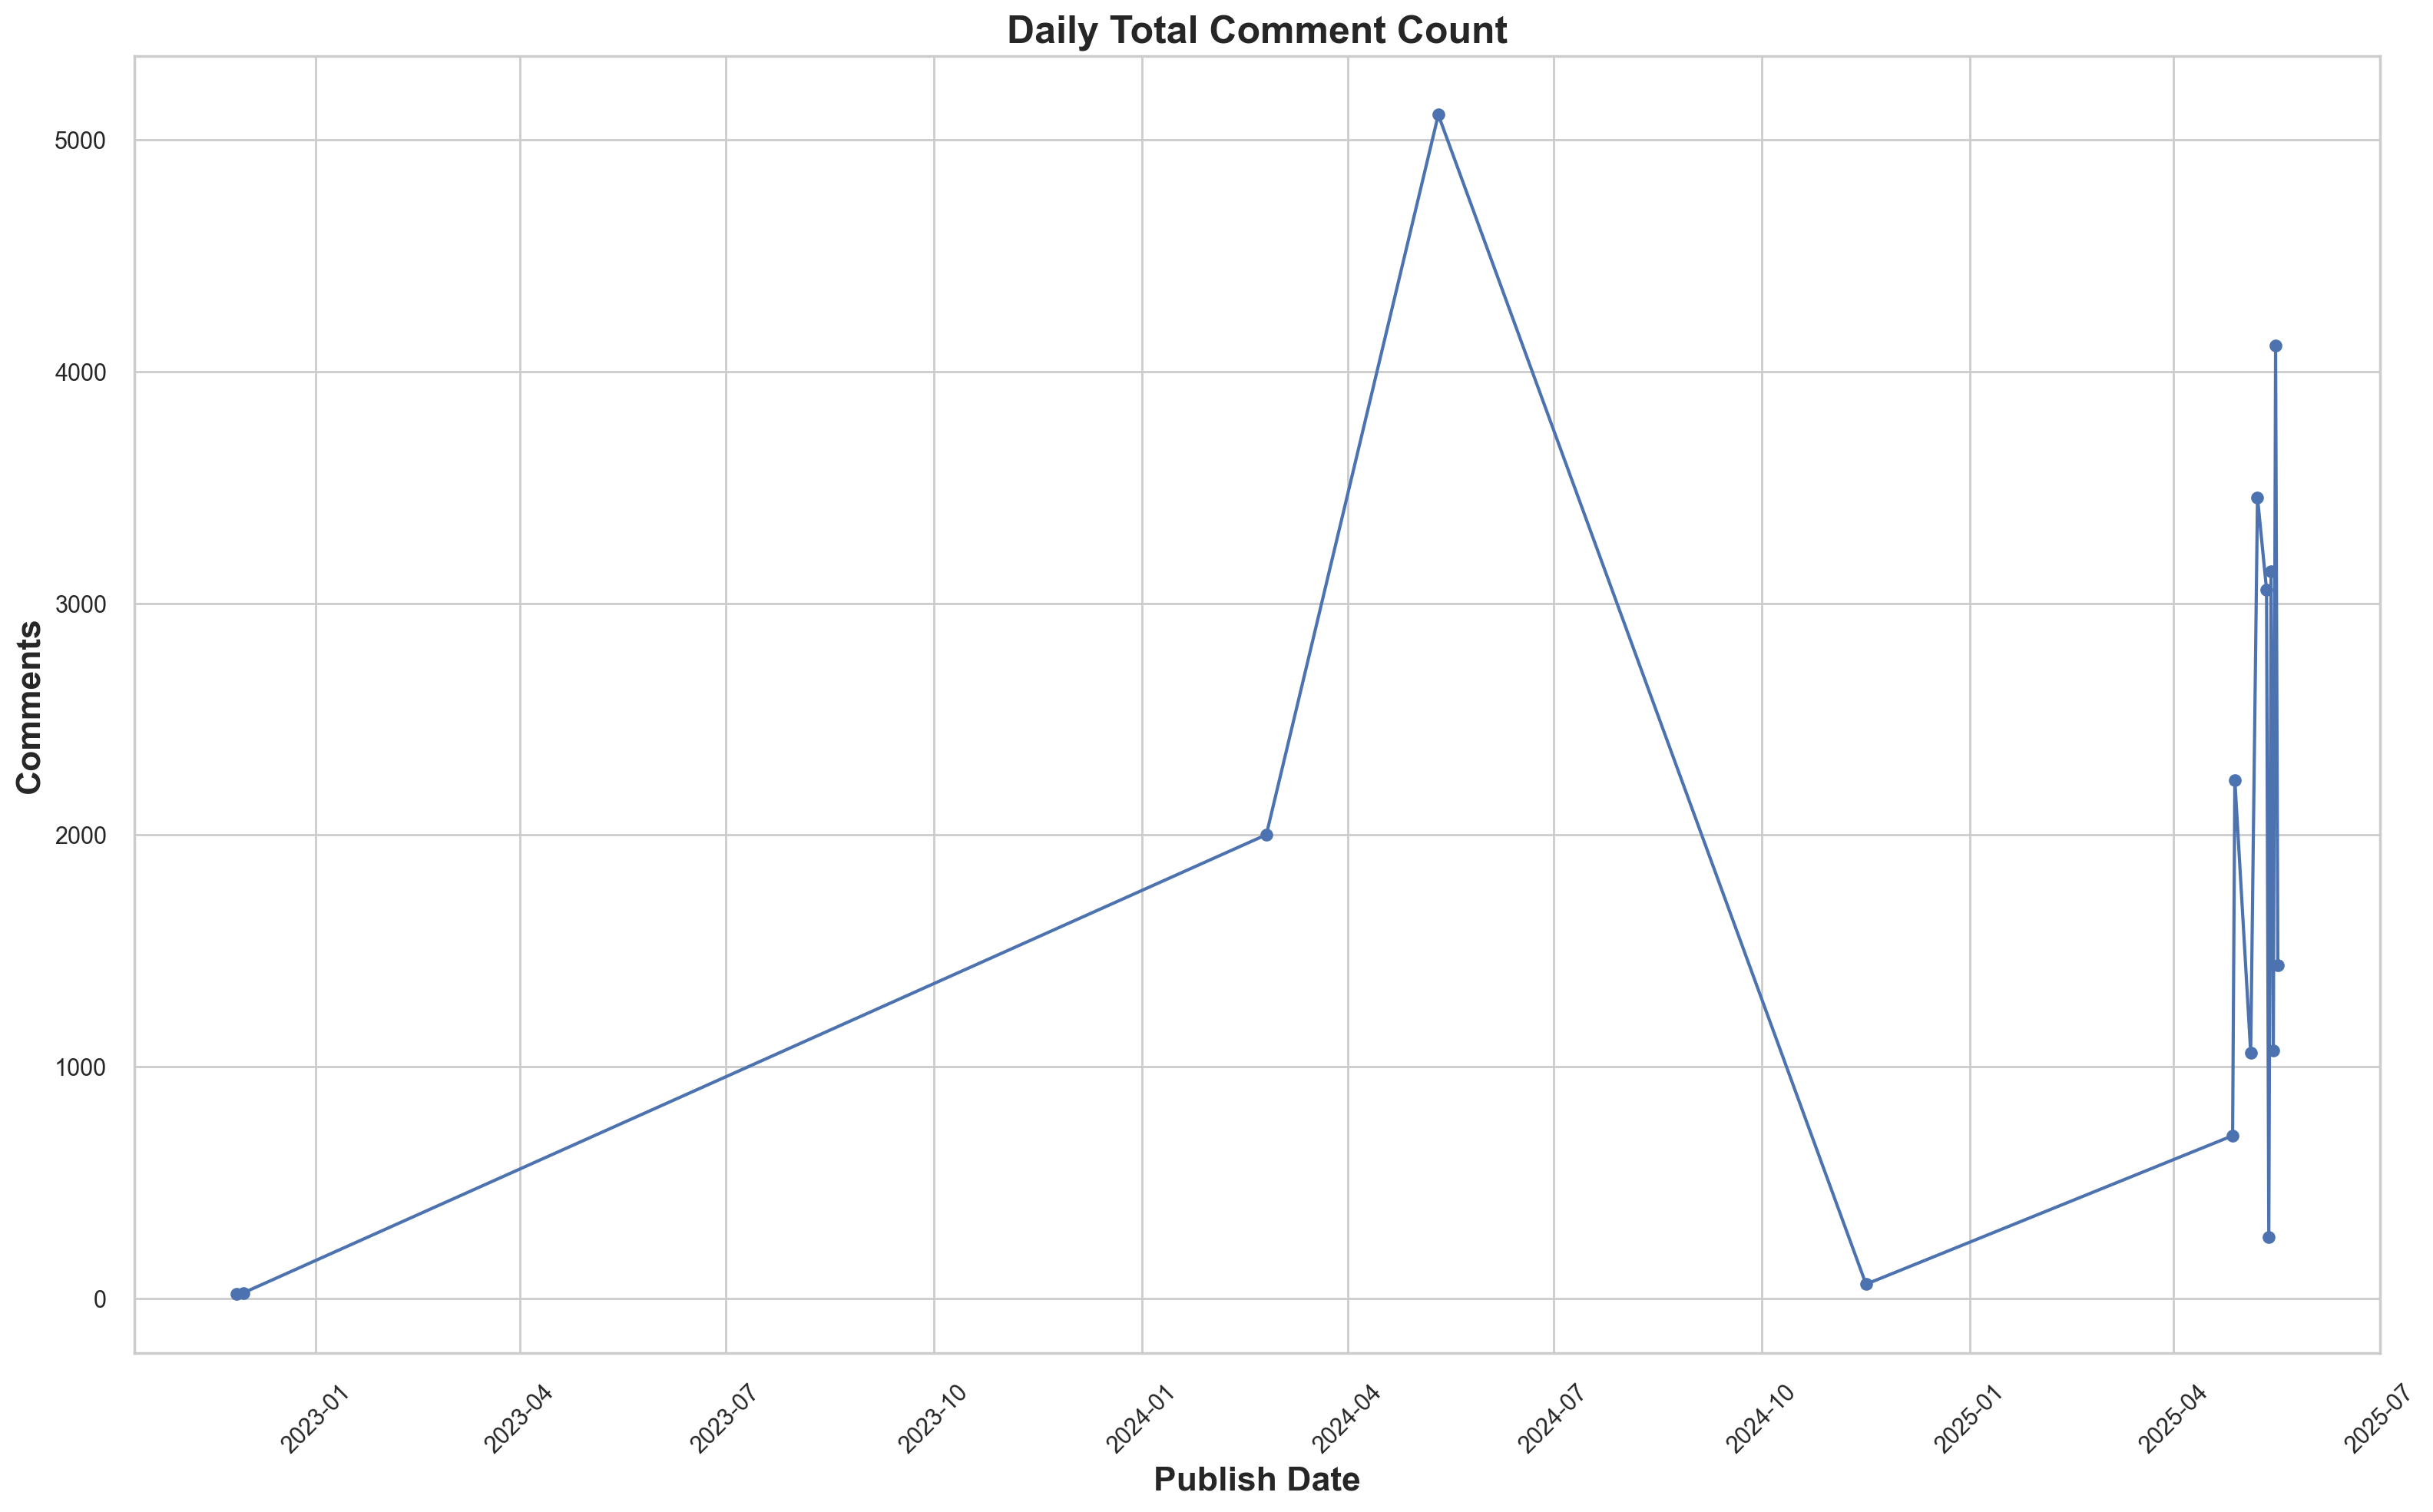

In [66]:
# parse dates
df_of_videos['videoPublishedAt'] = pd.to_datetime(df_of_videos['videoPublishedAt'])

# aggregate daily comment counts
daily_comments = (
    df_of_videos.groupby(df_of_videos['videoPublishedAt'].dt.date)
                ['videoCommentCount']
                .sum()
)

daily_comments.plot(marker='o')
plt.title("Daily Total Comment Count")
plt.xlabel("Publish Date")
plt.ylabel("Comments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
